# Analyse en Composantes Principales

## 1 - Bibliothèques et fonctions

### 1-1 Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

from utils import boxplot_columns
from PCA_class import PCA_Analyse

## Données

In [2]:
# Import des données
df = pd.read_csv("donnees_nettoyees.csv", index_col=1)
# df.drop(columns="code_pays", inplace=True)

In [3]:
df.head()

code_pays  population_totale  population_urbaine_tx  \
pays                                                                      
Afghanistan                 4         40099462.0               0.263138   
Albanie                     8          2854710.0               0.629691   
Algérie                    12         44177969.0               0.742606   
Angola                     24         34503774.0               0.674598   
Antigua-et-Barbuda         28            93219.0               0.243797   

                    dispo_alimentaire_qte_personne_jour  export_qte  \
pays                                                                  
Afghanistan                                        4.11       13.81   
Albanie                                           33.76        0.00   
Algérie                                           16.86     1616.35   
Angola                                            23.49        1.87   
Antigua-et-Barbuda                               169.21        0.75   

                    import_qte  production  croissance_par_habitant  \
pays                                                                  
Afghanistan           32613.38    28480.02                -6.267633   
Albanie               21929.50    13250.00                 8.578474   
Algérie                   0.40   273520.20                 1.790972   
Angola               240448.80    55384.74                 3.418421   
Antigua-et-Barbuda     5724.56       33.60                 3.405678   

                    PIB_par_habitant  stabilite_indice  
pays                                                    
Afghanistan               466.065575             -2.52  
Albanie                  5562.400440              0.20  
Algérie                  3942.852516             -0.99  
Angola                   2783.809186             -0.71  
Antigua-et-Barbuda      17122.683861              0.95

In [4]:
# Stockage du df pays et son code pour réalisation cartographie
df_code_pays = pd.DataFrame(df["code_pays"], df.index)

In [5]:
boxplot_columns(df)

### Transformation log

Plusieurs colonnes ont des fonctions de distribution qui semblent très loin de suivre une loi normale


Transformation de ces catégories avec np.log1p() : logn(x)+1


Il faudra penser à retransformer les données le cas échéant

In [6]:
# Sauvegarde du df original
df_original = df.copy()

In [7]:
# Transformation logarithmique de certaines features

liste_col = [
    'population_totale',
    'export_qte',
    'import_qte',
    'production',
    'PIB_par_habitant',
    'dispo_alimentaire_qte_personne_jour'
    ]
for col in liste_col:
    df[col] = np.log1p(df[col])
boxplot_columns(df)

In [8]:
df.head()

code_pays  population_totale  population_urbaine_tx  \
pays                                                                      
Afghanistan                 4          17.506874               0.263138   
Albanie                     8          14.864481               0.629691   
Algérie                    12          17.603737               0.742606   
Angola                     24          17.356579               0.674598   
Antigua-et-Barbuda         28          11.442718               0.243797   

                    dispo_alimentaire_qte_personne_jour  export_qte  \
pays                                                                  
Afghanistan                                    1.631199    2.695303   
Albanie                                        3.548467    0.000000   
Algérie                                        2.882564    7.388544   
Angola                                         3.198265    1.054312   
Antigua-et-Barbuda                             5.137033    0.559616   

                    import_qte  production  croissance_par_habitant  \
pays                                                                  
Afghanistan          10.392509   10.256993                -6.267633   
Albanie               9.995634    9.491828                 8.578474   
Algérie               0.336472   12.519134                 1.790972   
Angola               12.390267   10.922077                 3.418421   
Antigua-et-Barbuda    8.652696    3.543854                 3.405678   

                    PIB_par_habitant  stabilite_indice  
pays                                                    
Afghanistan                 6.146470             -2.52  
Albanie                     8.623965              0.20  
Algérie                     8.279913             -0.99  
Angola                      7.931935             -0.71  
Antigua-et-Barbuda          9.748218              0.95

In [9]:
df.shape

(182, 10)

Création d'un DF avec le code iso3 pour affichage ACP et map

In [10]:
# Import du fichier avec code pays
code_pays_iso = pd.read_csv("data/code_pays.csv")
code_pays_iso.head()

df_iso = df.merge(right=code_pays_iso, left_on="code_pays", right_on="country-code",)

In [11]:
df_iso.shape # -> la jointure a permis de récupérer tous les codes pays_iso

(182, 21)

In [12]:
pays_abrg = df_iso["alpha-3"]
pays_abrg.head()

0    AFG
1    ALB
2    DZA
3    AGO
4    ATG
Name: alpha-3, dtype: object

In [13]:
# Suppression de la colonne code_pays
df = df.drop("code_pays", axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, Afghanistan to Zambie
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   population_totale                    182 non-null    float64
 1   population_urbaine_tx                182 non-null    float64
 2   dispo_alimentaire_qte_personne_jour  182 non-null    float64
 3   export_qte                           182 non-null    float64
 4   import_qte                           182 non-null    float64
 5   production                           182 non-null    float64
 6   croissance_par_habitant              182 non-null    float64
 7   PIB_par_habitant                     182 non-null    float64
 8   stabilite_indice                     182 non-null    float64
dtypes: float64(9)
memory usage: 14.2+ KB


In [15]:
# Choix des colonnes :
col_choice = [
    'population_totale',
    'population_urbaine_tx',
    'dispo_alimentaire_qte_personne_jour',
    'export_qte',
    'import_qte',
    'production',
    # 'croissance_par_habitant',
    'PIB_par_habitant',
    'stabilite_indice'
     ]
df_prep = df[col_choice].copy()

In [16]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, Afghanistan to Zambie
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   population_totale                    182 non-null    float64
 1   population_urbaine_tx                182 non-null    float64
 2   dispo_alimentaire_qte_personne_jour  182 non-null    float64
 3   export_qte                           182 non-null    float64
 4   import_qte                           182 non-null    float64
 5   production                           182 non-null    float64
 6   PIB_par_habitant                     182 non-null    float64
 7   stabilite_indice                     182 non-null    float64
dtypes: float64(8)
memory usage: 12.8+ KB


## ACP

Importation des données actives

In [17]:
X = df_prep
# Dimension
print(X.shape)

# Nombre d'observations 
n = X.shape[0]

# Nombre de variables 
p = X.shape[1]
# Nomd des pays = labels
labels = X.index
# Nom des variables
features_names = df_prep.columns
# Affichage des données
display(X.head())

(182, 8)


population_totale  population_urbaine_tx  \
pays                                                           
Afghanistan                 17.506874               0.263138   
Albanie                     14.864481               0.629691   
Algérie                     17.603737               0.742606   
Angola                      17.356579               0.674598   
Antigua-et-Barbuda          11.442718               0.243797   

                    dispo_alimentaire_qte_personne_jour  export_qte  \
pays                                                                  
Afghanistan                                    1.631199    2.695303   
Albanie                                        3.548467    0.000000   
Algérie                                        2.882564    7.388544   
Angola                                         3.198265    1.054312   
Antigua-et-Barbuda                             5.137033    0.559616   

                    import_qte  production  PIB_par_habitant  stabilite_indice  
pays                                                                            
Afghanistan          10.392509   10.256993          6.146470             -2.52  
Albanie               9.995634    9.491828          8.623965              0.20  
Algérie               0.336472   12.519134          8.279913             -0.99  
Angola               12.390267   10.922077          7.931935             -0.71  
Antigua-et-Barbuda    8.652696    3.543854          9.748218              0.95

### Préparation des données

In [18]:
acp = PCA_Analyse()
acp.instance_fit_PCA(df_prep)

Description de X : 
n (observations): 182 
p (variables): 8
Les données ont été mises à l'echelle avec StandardScaler()
Paramètre de la PCA :
{'copy': True, 'iterated_power': 'auto', 'n_components': None, 'n_oversamples': 10, 'power_iteration_normalizer': 'auto', 'random_state': None, 'svd_solver': 'full', 'tol': 0.0, 'whiten': False}
L'entrainement des données avec l'ACP a été réalisée
----------------------------------------------------------------------------------------------------
Taille de : (182, 8)
Nombre de composantes : 8


In [19]:
# Données transformées
X_scaled = acp.X_scaled
print(f"Dimensions de X_scaled : {X_scaled.shape}")
df_X_scaled = pd.DataFrame(X_scaled,index=df_prep.index, columns=df_prep.columns)
df_X_scaled

Dimensions de X_scaled : (182, 8)


population_totale  \
pays                                                        
Afghanistan                                      0.833560   
Albanie                                         -0.456750   
Algérie                                          0.880859   
Angola                                           0.760170   
Antigua-et-Barbuda                              -2.127637   
...                                                   ...   
Ouzbékistan                                      0.754156   
Venezuela (République bolivarienne du)           0.661652   
Samoa                                           -1.711090   
Yémen                                            0.738138   
Zambie                                           0.480839   

                                        population_urbaine_tx  \
pays                                                            
Afghanistan                                         -1.466623   
Albanie                                              0.146175   
Algérie                                              0.642987   
Angola                                               0.343761   
Antigua-et-Barbuda                                  -1.551721   
...                                                       ...   
Ouzbékistan                                         -0.405656   
Venezuela (République bolivarienne du)               1.261812   
Samoa                                               -1.843771   
Yémen                                               -0.928405   
Zambie                                              -0.635998   

                                        dispo_alimentaire_qte_personne_jour  \
pays                                                                          
Afghanistan                                                       -1.894672   
Albanie                                                           -0.086903   
Algérie                                                           -0.714776   
Angola                                                            -0.417105   
Antigua-et-Barbuda                                                 1.410936   
...                                                                     ...   
Ouzbékistan                                                       -0.775277   
Venezuela (République bolivarienne du)                             0.141125   
Samoa                                                              1.521716   
Yémen                                                             -0.234287   
Zambie                                                            -1.301104   

                                        export_qte  import_qte  production  \
pays                                                                         
Afghanistan                              -0.506168    0.467869   -0.120915   
Albanie                                  -1.087600    0.335521   -0.365343   
Algérie                                   0.506259   -2.885558    0.601715   
Angola                                   -0.860163    1.134069    0.091543   
Antigua-et-Barbuda                       -0.966879   -0.112314   -2.265394   
...                                            ...         ...         ...   
Ouzbékistan                              -0.090769    0.733980    0.347973   
Venezuela (République bolivarienne du)   -1.087600    0.161860    0.748010   
Samoa                                     0.140668    0.306450   -1.480077   
Yémen                                    -1.087600    0.969976    0.499914   
Zambie                                    0.875940    0.296558    0.062260   

                                        PIB_par_habitant  stabilite_indice  
pays                                                                        
Afghanistan                                    -1.777169         -2.476633  
Albanie                                        -0.031085          0.332276  
Algérie                                        -0

In [21]:
# Vérification des transformations

# Moyennes de Z (doit être comprise entre -1 et 1)
print(f"Moyennes : {np.mean(X_scaled, axis=0)}")

# Ecart-type (doit être égale à 1)
print(f"Ecart-types : {np.std(X_scaled, axis=0)}")



Moyennes : [ 8.00336598e-16  5.85612145e-17  6.66133815e-16 -2.44005060e-17
  3.46487186e-16  2.92806072e-16  1.27858652e-15 -3.41607085e-17]
Ecart-types : [1. 1. 1. 1. 1. 1. 1. 1.]


### Analyse en composantes principales

##### Instanciation de la PCA et calculs

In [22]:
# Calculs
X_transform = acp.X_transform

# Nombre de composantes calculées
print(f"Nombre de composantes : {acp.n_components}")

Nombre de composantes : 8


In [23]:
pd.DataFrame(X_transform, columns=np.arange(1, acp.n_components+1))

1         2         3         4         5         6         7  \
0   -3.404495  1.407067  1.461005 -0.055876 -0.114456  0.523136  0.444818   
1   -0.172242 -0.936148  0.441414  0.300909 -0.232179 -0.708278 -0.058029   
2   -1.108438  1.224875 -2.545911  0.827872 -0.875476  0.884191 -0.202341   
3   -0.558674  0.653963  1.323289  0.541799 -0.386352 -0.756187 -0.106937   
4    0.251409 -3.714903  0.128159 -0.495678  1.234115  0.169430  0.974538   
..        ...       ...       ...       ...       ...       ...       ...   
177 -0.813919  0.873080  0.766456 -0.516700 -0.076843 -0.460106 -0.354912   
178 -0.213045  1.015966  0.390815  1.972750 -0.465770 -0.557600  0.123645   
179  0.286903 -2.610176  0.361814 -1.182765  1.937572  0.538761 -0.005329   
180 -2.453281  1.374703  1.789734  1.187322  0.940593 -0.011648  0.169183   
181 -0.959550  0.805621  0.364300 -1.389603 -0.313894  0.354522 -0.691092   

            8  
0   -0.156987  
1   -0.165741  
2    0.196563  
3    0.160058  
4    0.426733  
..        ...  
177  0.050501  
178 -0.194001  
179  0.397941  
180 -0.133188  
181 -0.004227  

[182 rows x 8 columns]

##### Valeurs propres et scree plot

In [24]:
# variance expliquée

print(f"Valeurs propres associées aux plans factoriels :\n")
print(acp.eigval)

Valeurs propres associées aux plans factoriels :

[3.25285076 2.4158666  0.83419721 0.56156876 0.43371412 0.26506101
 0.16215864 0.0745829 ]


In [25]:
# Proportion de variance expliquée
print(f"{acp.acp.explained_variance_ratio_}")


[0.40660635 0.30198332 0.10427465 0.0701961  0.05421426 0.03313263
 0.02026983 0.00932286]


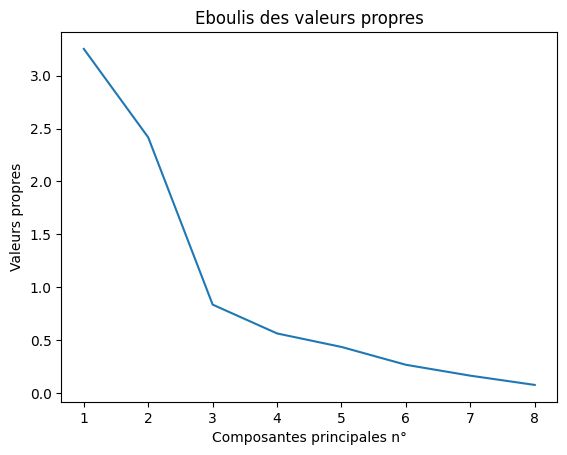

In [26]:
#scree plot
acp.scree_plot()

Proportion de variance expliquée par les composantes principales:
[0.40660635 0.70858967 0.81286432 0.88306042 0.93727468 0.97040731
 0.99067714 1.        ]


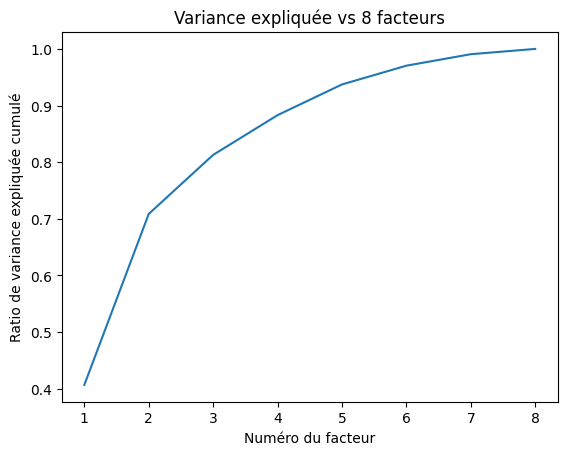

In [27]:
# Proportion de variance expliquée
print(f"Proportion de variance expliquée par les composantes principales:\n{acp.acp.explained_variance_ratio_.cumsum()}")
acp.explained_variance_vs_factors_plot()

In [28]:
# Calcul du nombre de composantes/ facteurs à conserver
seuil_acceptation_Karlis = 1 + 2 * np.sqrt((p-1)/(n-1))
seuil_acceptation_Karlis
n_composantes_conserves = ((acp.eigval > seuil_acceptation_Karlis)).sum()
print(f"Nombre de comosantes à conserver : {n_composantes_conserves}")
print(f"Valeurs propres des composantes : {acp.acp.explained_variance_ratio_[:n_composantes_conserves]}")
print(f"Ces composantes expliquent {acp.acp.explained_variance_ratio_[:n_composantes_conserves].sum(): .2%} de la variance")

Nombre de comosantes à conserver : 2
Valeurs propres des composantes : [0.40660635 0.30198332]
Ces composantes expliquent  70.86% de la variance


#### Représentation des individus

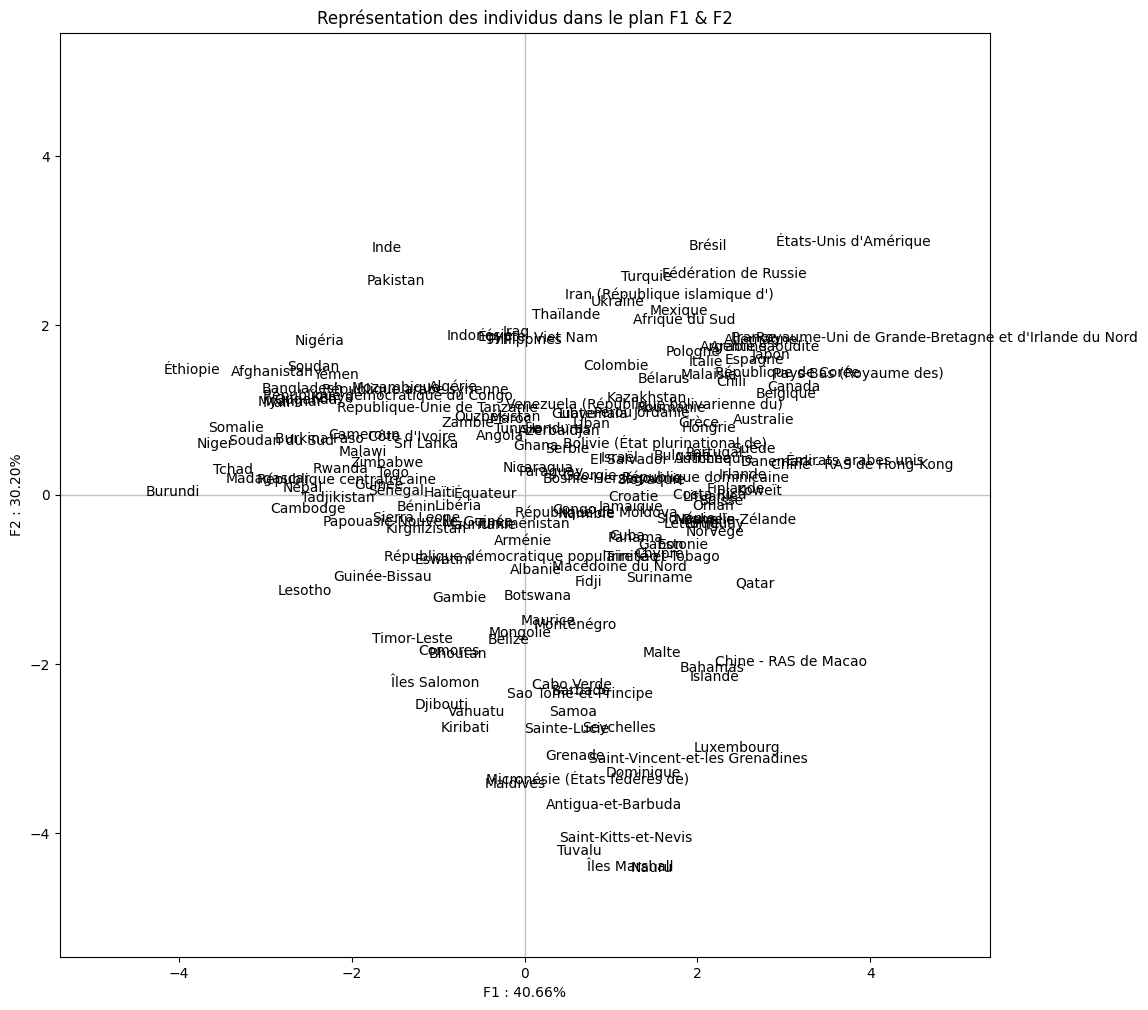

In [29]:
# # Nuage des individus sur les 2 premières composantes principales
acp.individuals_plot(plan_x=1, plan_y=2)

Qualité de la représentation

In [30]:
#contribution des individus dans l'inertie totale
contrib = acp.get_individuals_inertia_vs_total()
contrib.sort_values("d_i")

ID        d_i
142                 Serbie   0.915069
5              Azerbaïdjan   1.006095
116              Nicaragua   1.087090
17      Bosnie-Herzégovine   1.140662
105  République de Moldova   1.179203
..                     ...        ...
24                 Burundi  20.099195
49                Éthiopie  20.772333
93              Luxembourg  21.380216
121          Îles Marshall  23.117809
111                  Nauru  25.956508

[182 rows x 2 columns]

In [31]:
#qualité de représentation des individus - COS2
cos2 = acp.cos2_ind
display(pd.DataFrame({'id':X.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

id    COS2_1    COS2_2
0                               Afghanistan  0.714702  0.122081
1                                   Albanie  0.016687  0.492944
2                                   Algérie  0.106617  0.130193
3                                    Angola  0.088105  0.120723
4                        Antigua-et-Barbuda  0.003760  0.820999
..                                      ...       ...       ...
177                             Ouzbékistan  0.252340  0.290357
178  Venezuela (République bolivarienne du)  0.007959  0.180995
179                                   Samoa  0.006518  0.539516
180                                   Yémen  0.447396  0.140480
181                                  Zambie  0.212381  0.149707

[182 rows x 3 columns]

In [32]:
#vérifions la théorie - somme en ligne des cos2 = 1
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [33]:
#contributions aux axes
acp.get_individuals_contributions_axes().iloc[:,:2]

CTR_1     CTR_2
pays                                                      
Afghanistan                             0.019578  0.004503
Albanie                                 0.000050  0.001993
Algérie                                 0.002075  0.003412
Angola                                  0.000527  0.000973
Antigua-et-Barbuda                      0.000107  0.031387
...                                          ...       ...
Ouzbékistan                             0.001119  0.001734
Venezuela (République bolivarienne du)  0.000077  0.002348
Samoa                                   0.000139  0.015495
Yémen                                   0.010166  0.004298
Zambie                                  0.001555  0.001476

[182 rows x 2 columns]

In [34]:
#vérifions la théorie
print(np.sum(acp.get_individuals_contributions_axes().iloc[:,:2],axis=0))

CTR_1    1.0
CTR_2    1.0
dtype: float64


#### Représentation des variables

In [35]:
# corrélation des variables avec les axes
corr_var = acp.get_variable_correlation()
corr_var

COR_VAR_1  COR_VAR_2  COR_VAR_3  \
population_totale                    -0.149076   0.951565  -0.042884   
population_urbaine_tx                 0.801396   0.120847   0.018929   
dispo_alimentaire_qte_personne_jour   0.791406  -0.225859  -0.031759   
export_qte                            0.649438   0.562243  -0.078327   
import_qte                            0.499098   0.172963   0.831060   
production                            0.204097   0.897066  -0.223214   
PIB_par_habitant                      0.912194  -0.069450  -0.188639   
stabilite_indice                      0.646100  -0.537765  -0.220876   

                                     COR_VAR_4  COR_VAR_5  COR_VAR_6  \
population_totale                    -0.022305  -0.073599  -0.164157   
population_urbaine_tx                 0.404339  -0.393916   0.030610   
dispo_alimentaire_qte_personne_jour   0.314020   0.461959   0.030932   
export_qte                           -0.346293   0.023275   0.365096   
import_qte                           -0.132620   0.041422  -0.101530   
production                            0.049916   0.198651  -0.177793   
PIB_par_habitant                     -0.042582  -0.131474  -0.079528   
stabilite_indice                     -0.396435  -0.026760  -0.233839   

                                     COR_VAR_7  COR_VAR_8  
population_totale                     0.020392   0.192831  
population_urbaine_tx                -0.152079  -0.008742  
dispo_alimentaire_qte_personne_jour  -0.018807   0.091274  
export_qte                           -0.046022   0.010201  
import_qte                            0.009142  -0.025062  
production                           -0.059469  -0.163375  
PIB_par_habitant                      0.318805  -0.020841  
stabilite_indice                     -0.175745   0.033674

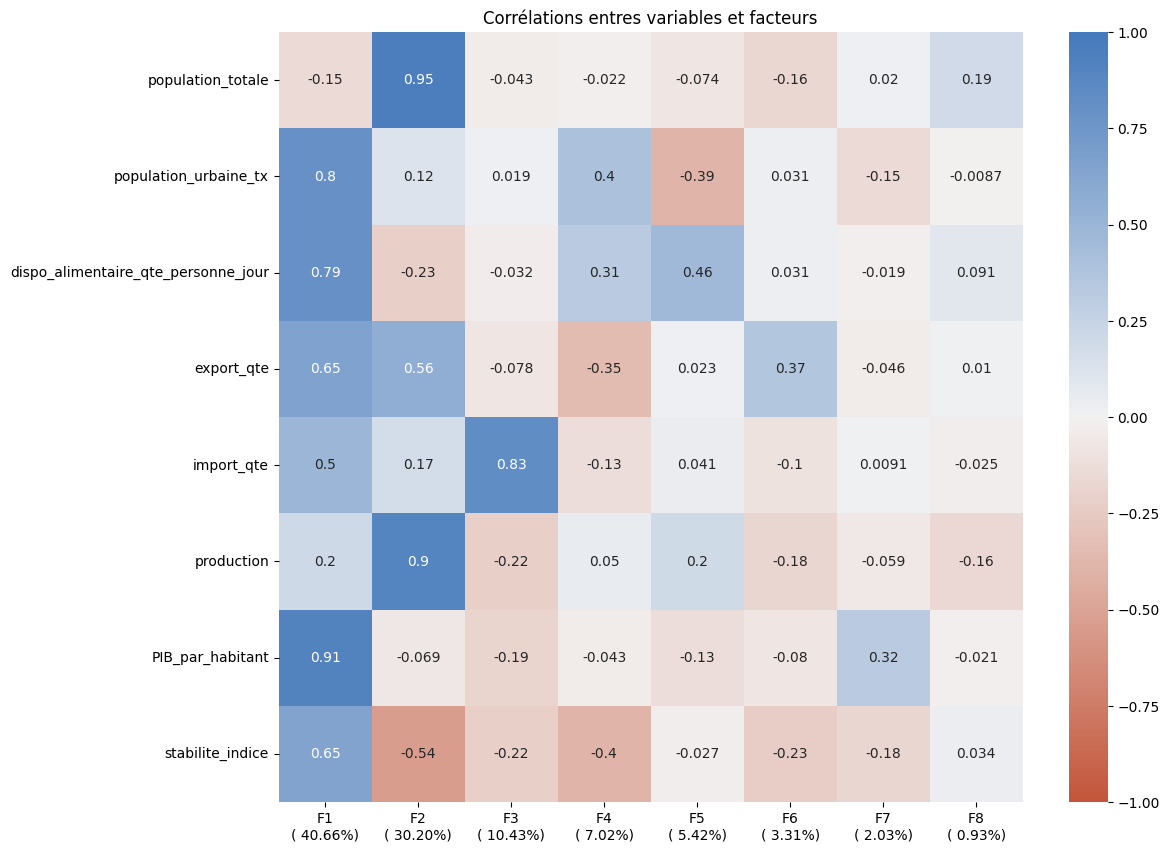

In [36]:
acp.correlation_variable_factor_plot()

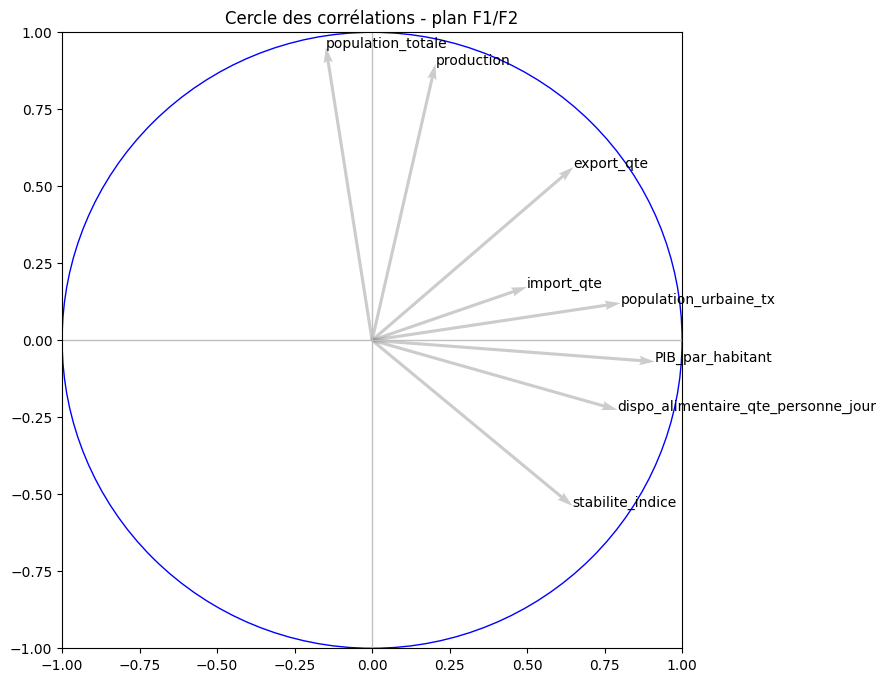

In [37]:
#cercle des corrélations F1/F2
acp.correlation_circle_plot()

Qualité de représentation des variables (COS²)

In [38]:
#cosinus carré des variables
acp.get_cos2_variable().iloc[:,:2]

COS2_VAR_0  COS2_VAR_1
population_totale                      0.006832    0.374804
population_urbaine_tx                  0.197438    0.006045
dispo_alimentaire_qte_personne_jour    0.192546    0.021115
export_qte                             0.129662    0.130850
import_qte                             0.076579    0.012383
production                             0.012806    0.333101
PIB_par_habitant                       0.255806    0.001997
stabilite_indice                       0.128332    0.119705

Contribution des variables aux axes (CTR)

In [39]:
# contributions des variables aux axes
contrib_var = acp.get_variables_contributions_to_axes()
contrib_var

CTR_VAR_0  CTR_VAR_1  CTR_VAR_2  \
population_totale                     0.006832   0.374804   0.002205   
population_urbaine_tx                 0.197438   0.006045   0.000430   
dispo_alimentaire_qte_personne_jour   0.192546   0.021115   0.001209   
export_qte                            0.129662   0.130850   0.007355   
import_qte                            0.076579   0.012383   0.827935   
production                            0.012806   0.333101   0.059727   
PIB_par_habitant                      0.255806   0.001997   0.042657   
stabilite_indice                      0.128332   0.119705   0.058483   

                                     CTR_VAR_3  CTR_VAR_4  CTR_VAR_5  \
population_totale                     0.000886   0.012489   0.101665   
population_urbaine_tx                 0.291131   0.357770   0.003535   
dispo_alimentaire_qte_personne_jour   0.175595   0.492043   0.003610   
export_qte                            0.213542   0.001249   0.502885   
import_qte                            0.031320   0.003956   0.038890   
production                            0.004437   0.090987   0.119257   
PIB_par_habitant                      0.003229   0.039854   0.023862   
stabilite_indice                      0.279861   0.001651   0.206295   

                                     CTR_VAR_6  CTR_VAR_7  
population_totale                     0.002564   0.498554  
population_urbaine_tx                 0.142627   0.001025  
dispo_alimentaire_qte_personne_jour   0.002181   0.111701  
export_qte                            0.013062   0.001395  
import_qte                            0.000515   0.008422  
production                            0.021809   0.357875  
PIB_par_habitant                      0.626772   0.005824  
stabilite_indice                      0.190469   0.015204

<Axes: >

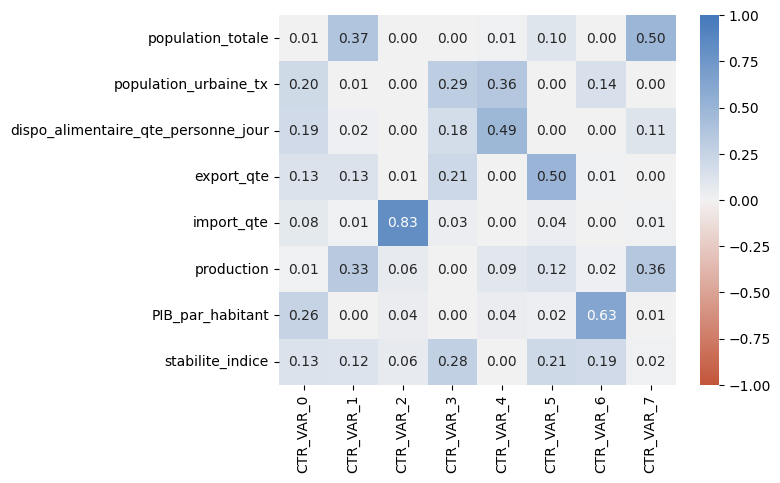

In [40]:
sns.heatmap(contrib_var, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 250, as_cmap=True))

## Clustering - ACH

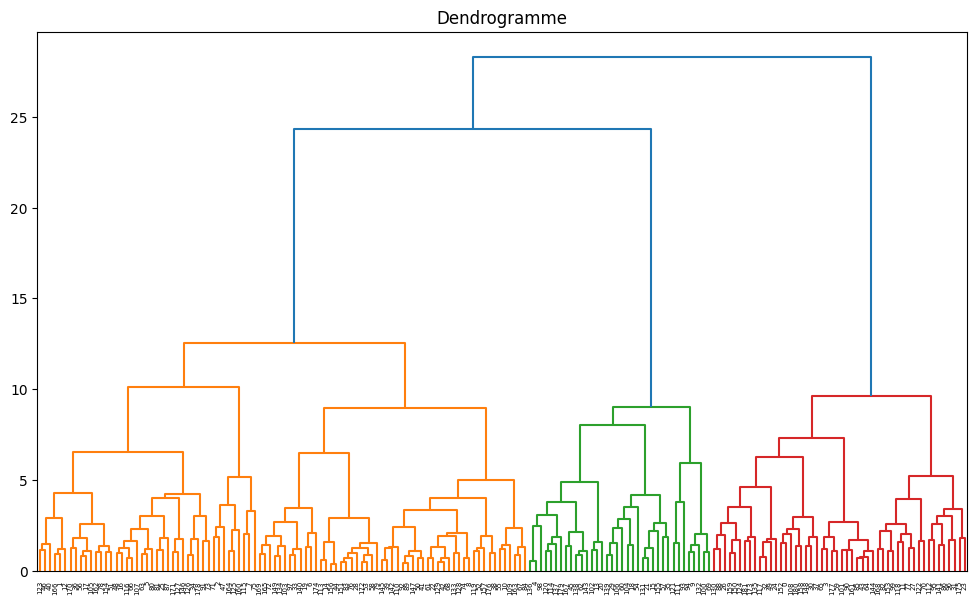

In [41]:
# Dendrogramme avec ACH
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, leaf_rotation=90)
plt.title("Dendrogramme")
plt.show()

Le dendogramme fait apparaître une séparation claire en 3 clusters à utiliser pour la CAH

In [42]:
# Entrainement du modéle de Classification Ascendante Hiérarchique

ach = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward') # instanciation
ach.fit(X_scaled) # Entrainement du modèle

AgglomerativeClustering(n_clusters=3)

Les données utilisées sont celles standardisées avant l'ACP par un Standard Scaler

In [43]:
# Récupération des numeros des clusters créés
ach_labels = ach.labels_
print("Etiquettes de clusters : ", labels)

Etiquettes de clusters :  Index(['Afghanistan', 'Albanie', 'Algérie', 'Angola', 'Antigua-et-Barbuda',
       'Azerbaïdjan', 'Argentine', 'Australie', 'Autriche', 'Bahamas',
       ...
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord',
       'République-Unie de Tanzanie', 'États-Unis d'Amérique', 'Burkina Faso',
       'Uruguay', 'Ouzbékistan', 'Venezuela (République bolivarienne du)',
       'Samoa', 'Yémen', 'Zambie'],
      dtype='object', name='pays', length=182)


In [44]:
ach_labels.shape


(182,)

In [45]:
X_scaled.shape

(182, 8)

In [46]:
features_names

Index(['population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'PIB_par_habitant', 'stabilite_indice'],
      dtype='object')

In [47]:
# Création d'un dataframe avec les données standardisées
df_X_scaled_CAH = pd.DataFrame(data=X_scaled, index=labels, columns=features_names)
df_X_scaled_CAH["CAH"] = ach_labels
df_X_scaled_CAH.head()


population_totale  population_urbaine_tx  \
pays                                                           
Afghanistan                  0.833560              -1.466623   
Albanie                     -0.456750               0.146175   
Algérie                      0.880859               0.642987   
Angola                       0.760170               0.343761   
Antigua-et-Barbuda          -2.127637              -1.551721   

                    dispo_alimentaire_qte_personne_jour  export_qte  \
pays                                                                  
Afghanistan                                   -1.894672   -0.506168   
Albanie                                       -0.086903   -1.087600   
Algérie                                       -0.714776    0.506259   
Angola                                        -0.417105   -0.860163   
Antigua-et-Barbuda                             1.410936   -0.966879   

                    import_qte  production  PIB_par_habitant  \
pays                                                           
Afghanistan           0.467869   -0.120915         -1.777169   
Albanie               0.335521   -0.365343         -0.031085   
Algérie              -2.885558    0.601715         -0.273565   
Angola                1.134069    0.091543         -0.518812   
Antigua-et-Barbuda   -0.112314   -2.265394          0.761264   

                    stabilite_indice  CAH  
pays                                       
Afghanistan                -2.476633    1  
Albanie                     0.332276    0  
Algérie                    -0.896622    0  
Angola                     -0.607470    1  
Antigua-et-Barbuda          1.106791    2

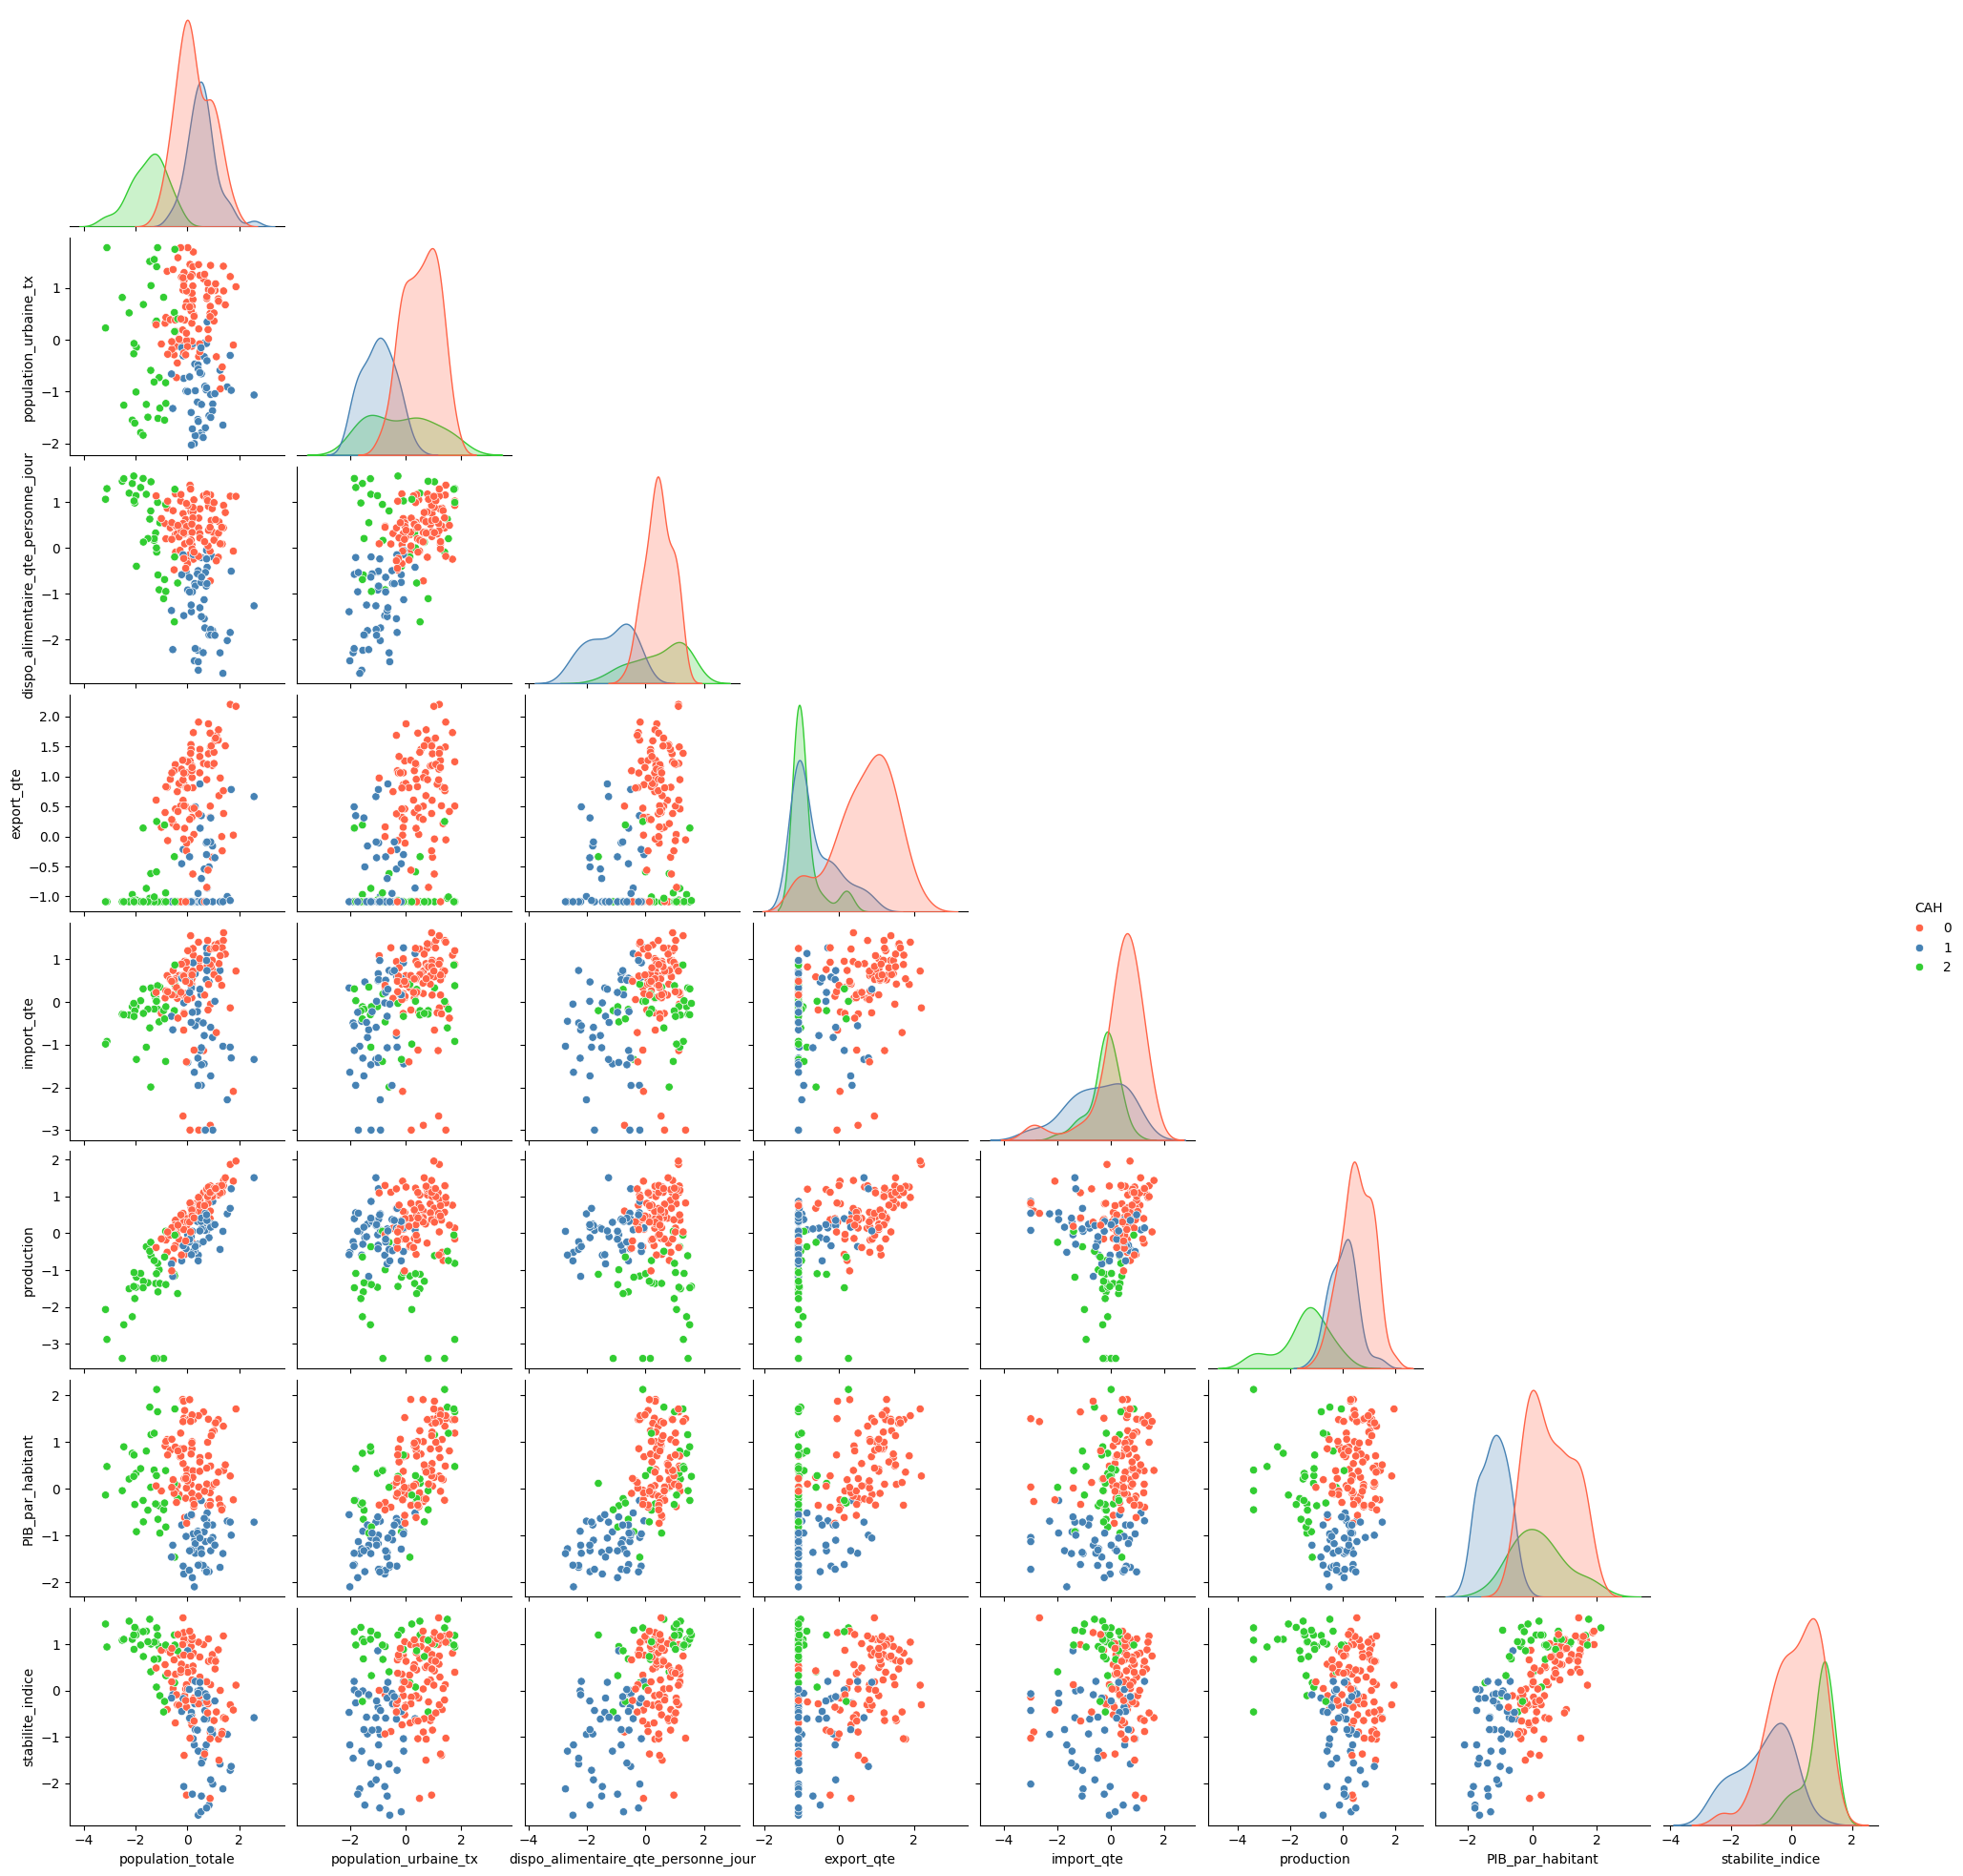

In [48]:
# Visualisation des clusters issus de la CAH en fonction des différentes paires de variables
custom_palette = ["#FF6347", "#4682B4", "#32CD32"]
sns.pairplot(data=df_X_scaled_CAH, hue="CAH", palette=custom_palette, corner=True)

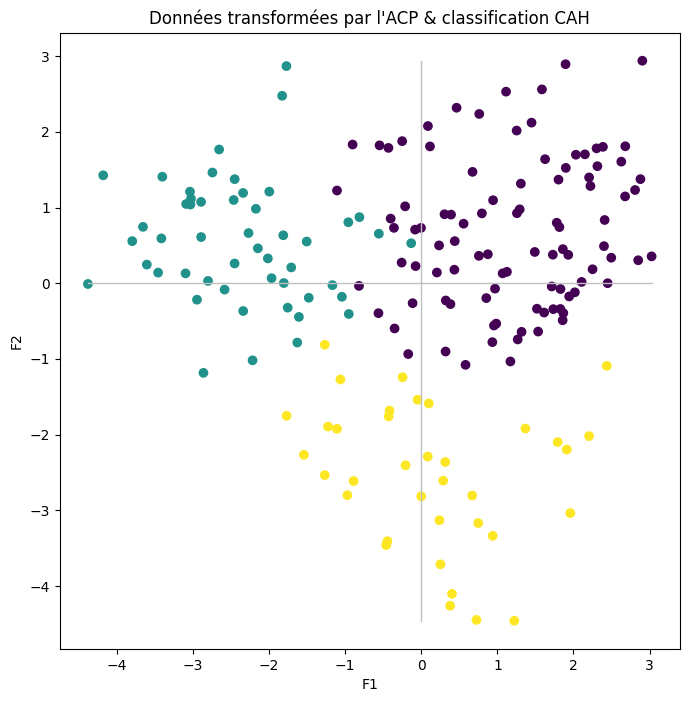

In [49]:
# Clusters CAH et F1 / F2
plt.figure(figsize=(8,8))
plt.scatter(x=X_transform[:,0], y=X_transform[:,1],c=ach_labels)
# for i in range(X_transform.shape[0]):
#     plt.annotate(text=labels.values[i],xy=(X_transform[i,0],X_transform[i,1]), fontsize=8)

plt.plot([0, 0], (X_transform[:,1].min(), X_transform[:,1].max()), color='silver', linestyle='-', linewidth=1)
plt.plot((X_transform[:,0].min(), X_transform[:,0].max()), [0, 0], color='silver', linestyle='-', linewidth=1)
plt.title("Données transformées par l'ACP & classification CAH")
plt.xlabel("F1")
plt.ylabel("F2")
plt.show()

## Clustering - Kmeans

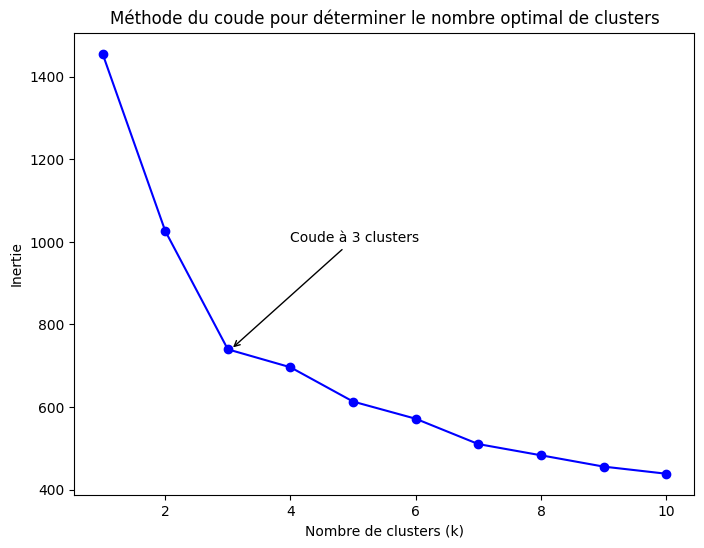

In [50]:
# Méthode du coude pour déterminer le nombre optimal de clusters
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.annotate(text="Coude à 3 clusters",xy=(3.05,740), xytext=(4,1000), arrowprops=dict(arrowstyle="->"))
# plt.arrow(x=4, y=1000, dx=-1, dy= -90, arrowprops=dict(arrowstyle="->"))
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

In [51]:
# Créer le modèle KMeans avec 3 clusters (k=3)
kmeans = KMeans(n_clusters=3,
                 random_state=42,
                 init='k-means++',
                 n_init=10                 ,
                 )

# Ajuster le modèle aux données
kmeans.fit(X_transform)
# Étiquettes des clusters : Indique le cluster auquel chaque point de données appartient.
km_cluster_labels = kmeans.labels_
print("Étiquettes des clusters :", labels)
# Centroïdes des clusters : Coordonnées des centres des clusters
centroids = kmeans.cluster_centers_
print("Centroïdes des clusters :", centroids)
# Inertie : Somme des distances au carré des échantillons à leur centroïde le plus proche
inertia = kmeans.inertia_
print("Inertie :", inertia)

Étiquettes des clusters : Index(['Afghanistan', 'Albanie', 'Algérie', 'Angola', 'Antigua-et-Barbuda',
       'Azerbaïdjan', 'Argentine', 'Australie', 'Autriche', 'Bahamas',
       ...
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord',
       'République-Unie de Tanzanie', 'États-Unis d'Amérique', 'Burkina Faso',
       'Uruguay', 'Ouzbékistan', 'Venezuela (République bolivarienne du)',
       'Samoa', 'Yémen', 'Zambie'],
      dtype='object', name='pays', length=182)
Centroïdes des clusters : [[ 1.30907855e+00  7.37317341e-01  4.46464053e-02  5.87660503e-03
   4.78052097e-02  4.13537816e-02 -8.97296390e-05 -2.38201224e-02]
 [-2.25073950e+00  5.16265776e-01 -1.02961529e-01 -5.50384331e-02
  -1.15661527e-01 -6.82440027e-02 -2.42818398e-03  4.69003313e-03]
 [ 1.29024158e-01 -2.39742552e+00  4.06767311e-02  6.27963471e-02
   5.10527901e-02  1.20245761e-04  3.56686853e-03  4.78648488e-02]]
Inertie : 739.635469264311


Comparaison de la performance du modèle entre Kmeans et CAH

In [52]:
df_X_scaled_Kmeans = pd.DataFrame(data=X_transform, index=labels, columns=features_names)
df_X_scaled_Kmeans["kmeans"] = km_cluster_labels
df_X_scaled_Kmeans.head()

population_totale  population_urbaine_tx  \
pays                                                           
Afghanistan                 -3.404495               1.407067   
Albanie                     -0.172242              -0.936148   
Algérie                     -1.108438               1.224875   
Angola                      -0.558674               0.653963   
Antigua-et-Barbuda           0.251409              -3.714903   

                    dispo_alimentaire_qte_personne_jour  export_qte  \
pays                                                                  
Afghanistan                                    1.461005   -0.055876   
Albanie                                        0.441414    0.300909   
Algérie                                       -2.545911    0.827872   
Angola                                         1.323289    0.541799   
Antigua-et-Barbuda                             0.128159   -0.495678   

                    import_qte  production  PIB_par_habitant  \
pays                                                           
Afghanistan          -0.114456    0.523136          0.444818   
Albanie              -0.232179   -0.708278         -0.058029   
Algérie              -0.875476    0.884191         -0.202341   
Angola               -0.386352   -0.756187         -0.106937   
Antigua-et-Barbuda    1.234115    0.169430          0.974538   

                    stabilite_indice  kmeans  
pays                                          
Afghanistan                -0.156987       1  
Albanie                    -0.165741       2  
Algérie                     0.196563       1  
Angola                      0.160058       1  
Antigua-et-Barbuda          0.426733       2

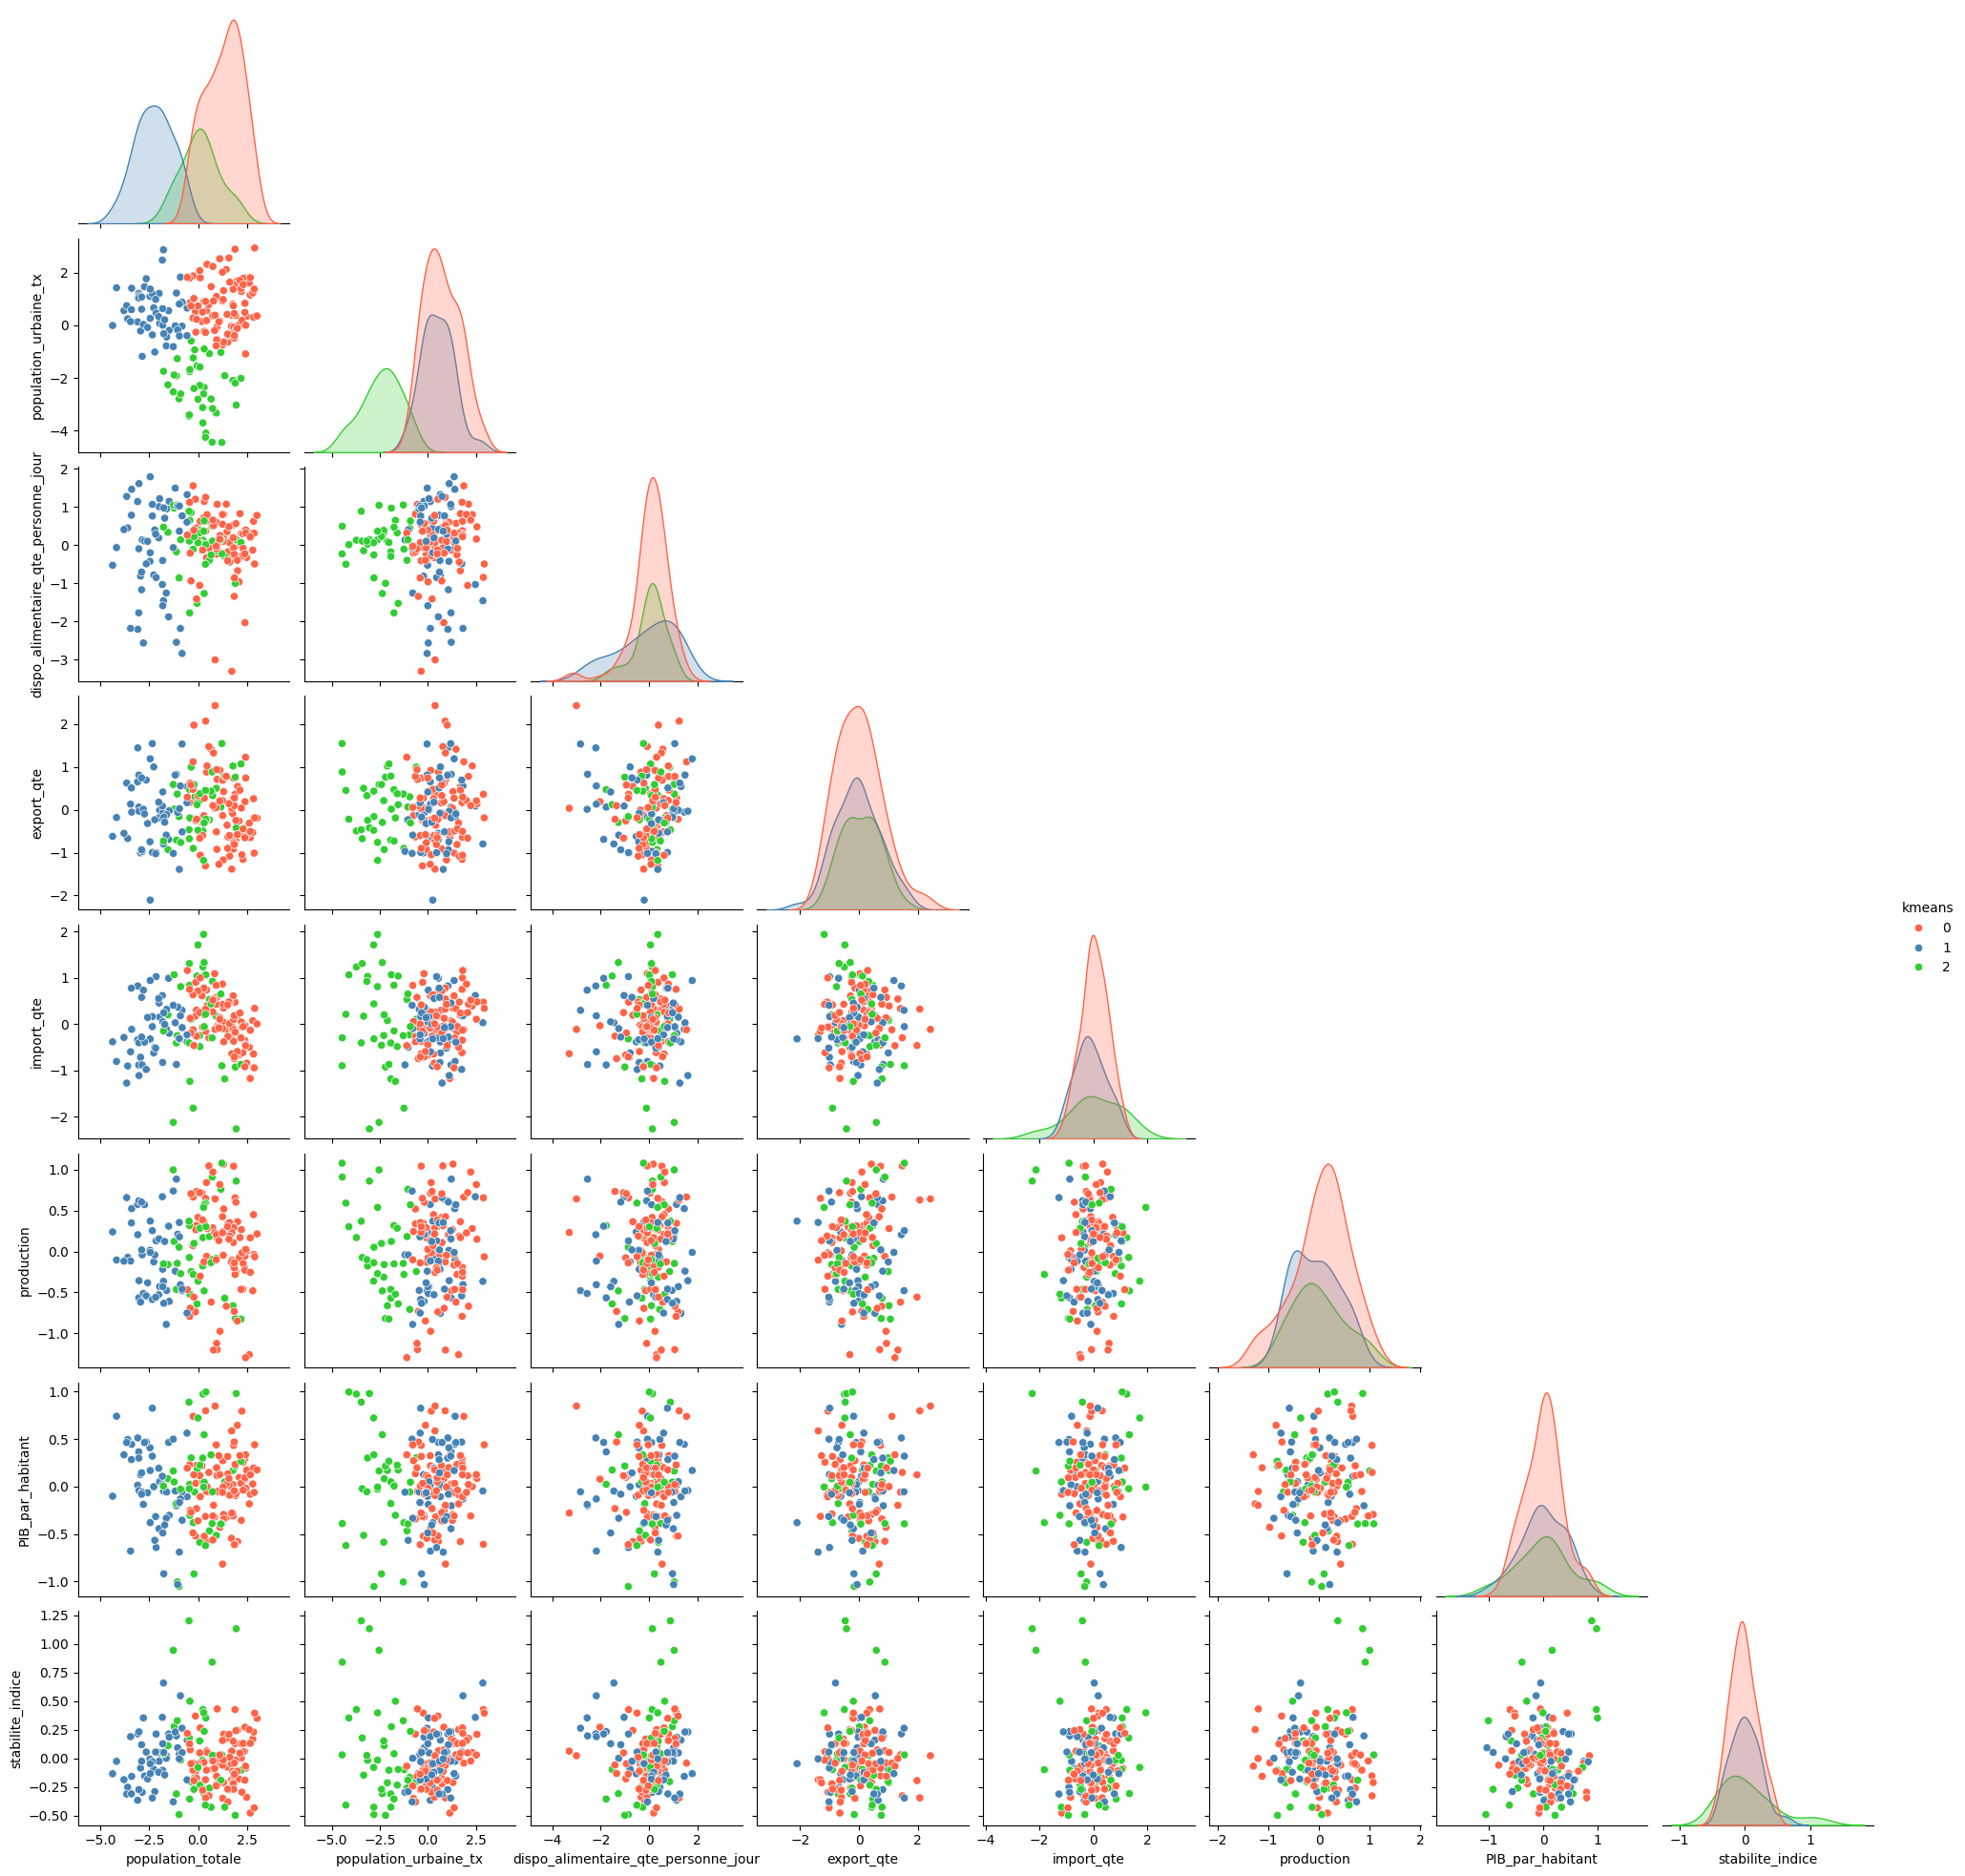

In [53]:
# Visualisation des clusters avec données transformées (1+log pour certaines et standaridisée)
custom_palette = ["#FF6347", "#4682B4", "#32CD32"]
sns.pairplot(data=df_X_scaled_Kmeans, hue="kmeans", palette=custom_palette, corner=True)
plt.show()

Ajout des résultats de classification au dataframe original

In [54]:
# ajout des clusters_kmeans au df_original
df_original["categ_kmeans"] = km_cluster_labels
df_original["categ_ACH"] = ach_labels

# ajout des clusters_kmeans au df_prep
df_prep["categ_kmeans"] = km_cluster_labels
df_prep["categ_ACH"] = ach_labels

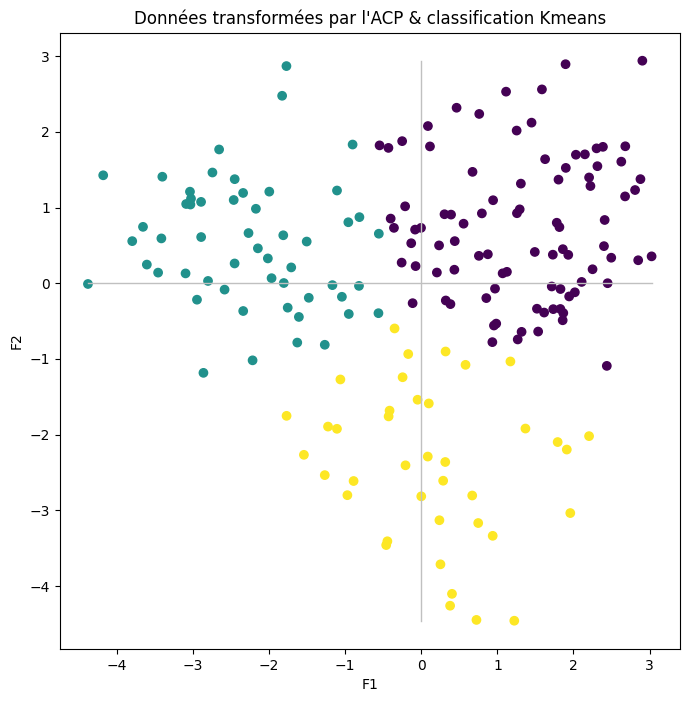

In [55]:
# Clusters kmeans et F1 / F2
plt.figure(figsize=(8,8))
plt.scatter(x=X_transform[:,0], y=X_transform[:,1],c=km_cluster_labels)
# for i in range(X_transform.shape[0]):
#     plt.annotate(text=labels.values[i],xy=(X_transform[i,0],X_transform[i,1]), fontsize=8)

plt.plot([0, 0], (X_transform[:,1].min(), X_transform[:,1].max()), color='silver', linestyle='-', linewidth=1)
plt.plot((X_transform[:,0].min(), X_transform[:,0].max()), [0, 0], color='silver', linestyle='-', linewidth=1)
plt.title("Données transformées par l'ACP & classification Kmeans")
plt.xlabel("F1")
plt.ylabel("F2")
plt.show()

## Choix du modéle de clustering

In [56]:
# Calcul du score de silhouette
kmeans_labels = kmeans.labels_
kmeans_silhouette = silhouette_score(X_transform, kmeans_labels)
ach_labels = ach.labels_
ach_silhouette = silhouette_score(X_transform, ach_labels)

print(f"Score silhouette :")
print(f"CAH : {ach_silhouette}")
print(f"K-means : {kmeans_silhouette}")


Score silhouette :
CAH : 0.30922962484688454
K-means : 0.31510453423087104


In [57]:
np.unique(km_cluster_labels)

array([0, 1, 2], dtype=int32)

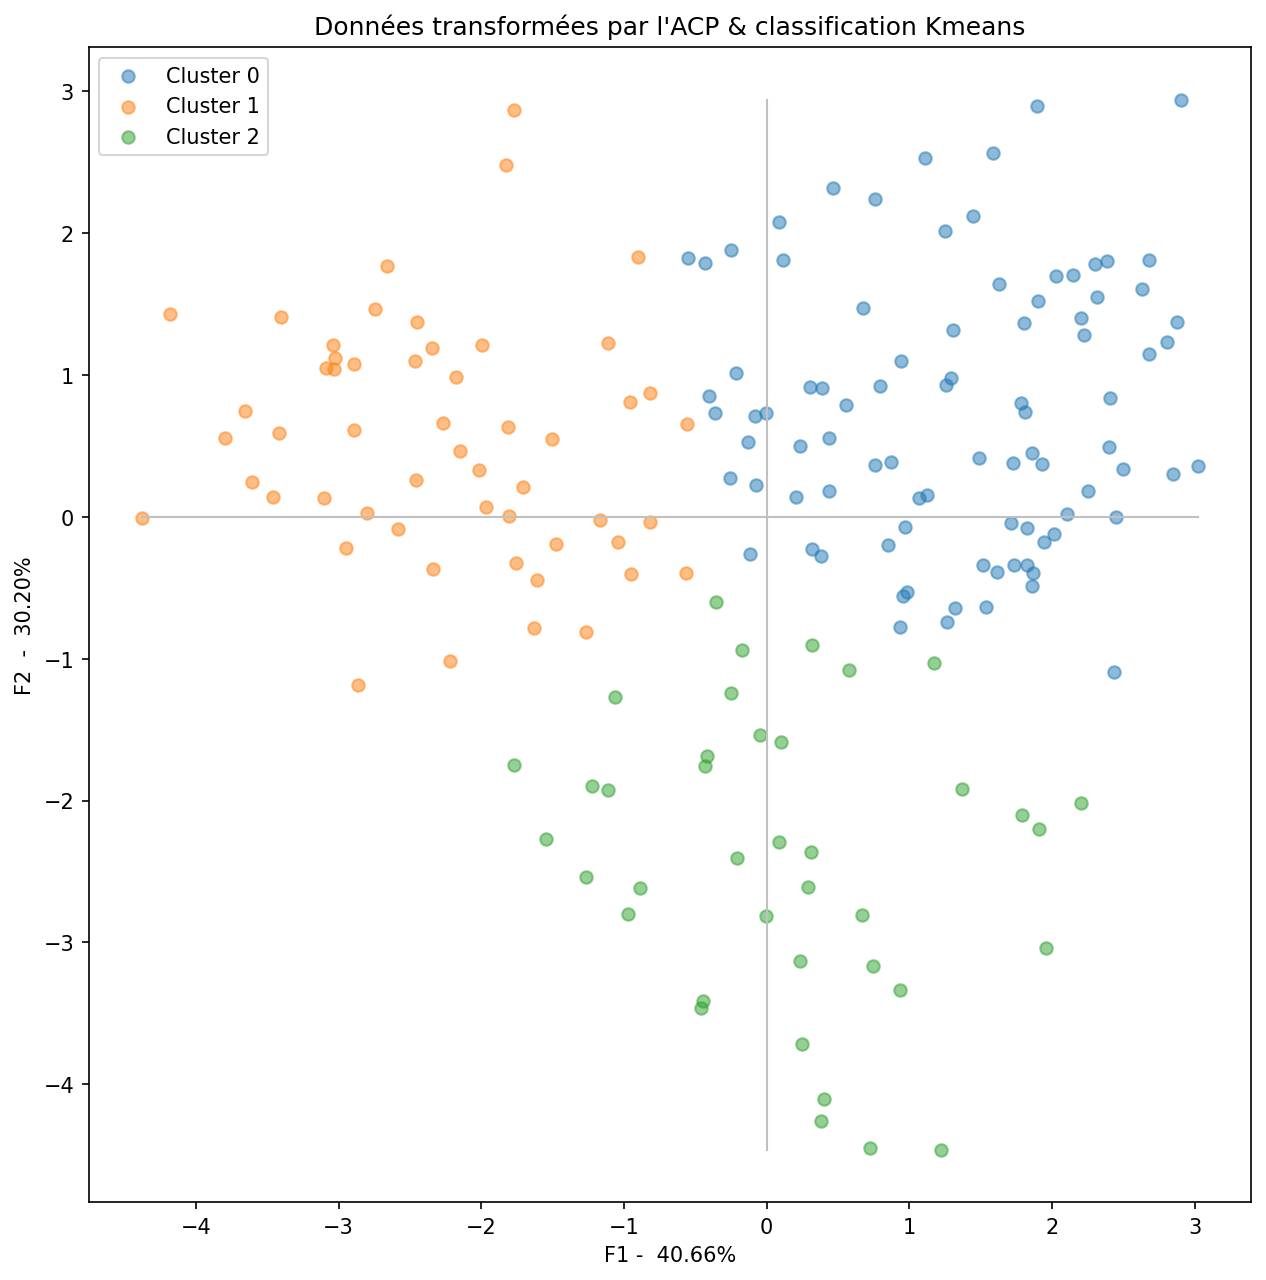

In [58]:
# Clusters kmeans et F1 / F2
plt.figure(figsize=(10,10), dpi=150)

n_clusters = len(set(km_cluster_labels))

# Crée un scatter plot pour chaque cluster avec une couleur différente
for cluster in range(n_clusters):
    plt.scatter(
        x=X_transform[km_cluster_labels == cluster, 0],
        y=X_transform[km_cluster_labels == cluster, 1],
        alpha=0.5,
        label=f'Cluster {cluster}'
    )   
plt.legend()
# Axes
plt.plot([0, 0], (X_transform[:,1].min(), X_transform[:,1].max()), color='silver', linestyle='-', linewidth=1)
plt.plot((X_transform[:,0].min(), X_transform[:,0].max()), [0, 0], color='silver', linestyle='-', linewidth=1)

plt.title("Données transformées par l'ACP & classification Kmeans")
plt.xlabel(f"F1 - {acp.acp.explained_variance_ratio_[0]: .2%}")
plt.ylabel(f"F2  - {acp.acp.explained_variance_ratio_[1]: .2%}")

plt.show()

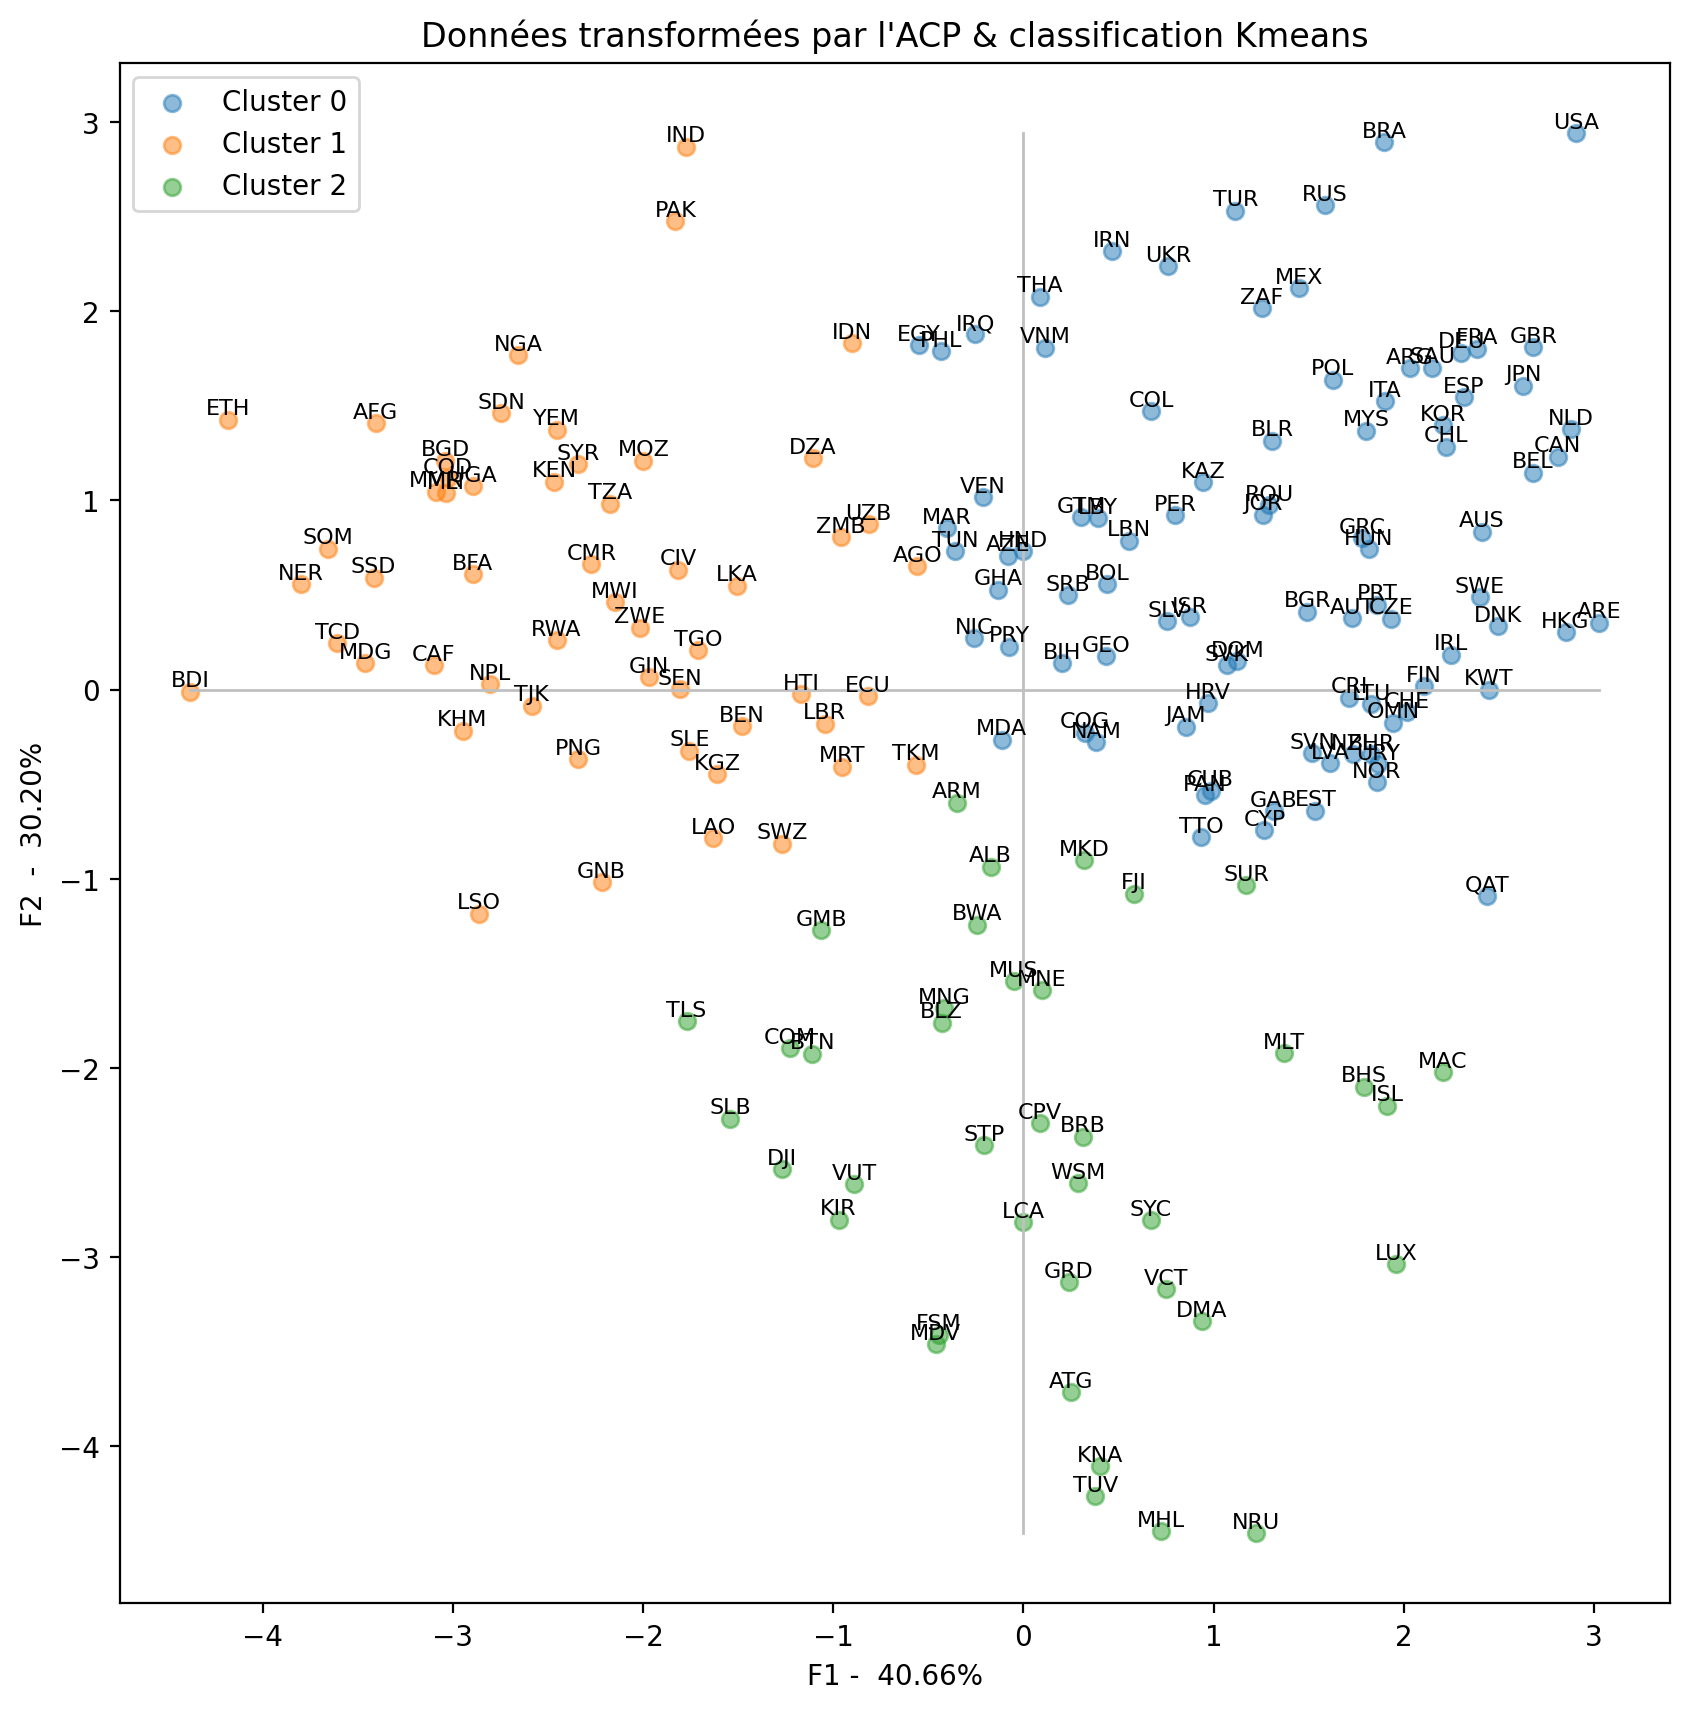

In [59]:
# Clusters kmeans et F1 / F2
plt.figure(figsize=(10,10), dpi=200)
n_clusters = len(set(km_cluster_labels))

# Créer un scatter plot pour chaque cluster avec une couleur différente
for cluster in range(n_clusters):
    plt.scatter(
        x=X_transform[km_cluster_labels == cluster, 0],
        y=X_transform[km_cluster_labels == cluster, 1],
        alpha=0.5,
        label=f'Cluster {cluster}'  # Etiquette pour la légende
    )   
# Ajoute les codes iso des pays
for i in range(X_transform.shape[0]):
    plt.annotate(
        text=pays_abrg.values[i],
        xy=(X_transform[i,0], X_transform[i,1]),
        fontsize=8,
        ha='center',
        va="center",
        textcoords="offset points",
        xytext=(0, 4)
    )
plt.legend()

plt.plot([0, 0], (X_transform[:,1].min(), X_transform[:,1].max()), color='silver', linestyle='-', linewidth=1)
plt.plot((X_transform[:,0].min(), X_transform[:,0].max()), [0, 0], color='silver', linestyle='-', linewidth=1)

plt.title("Données transformées par l'ACP & classification Kmeans")
plt.xlabel(f"F1 - {acp.acp.explained_variance_ratio_[0]: .2%}")
plt.ylabel(f"F2  - {acp.acp.explained_variance_ratio_[1]: .2%}")

plt.show()

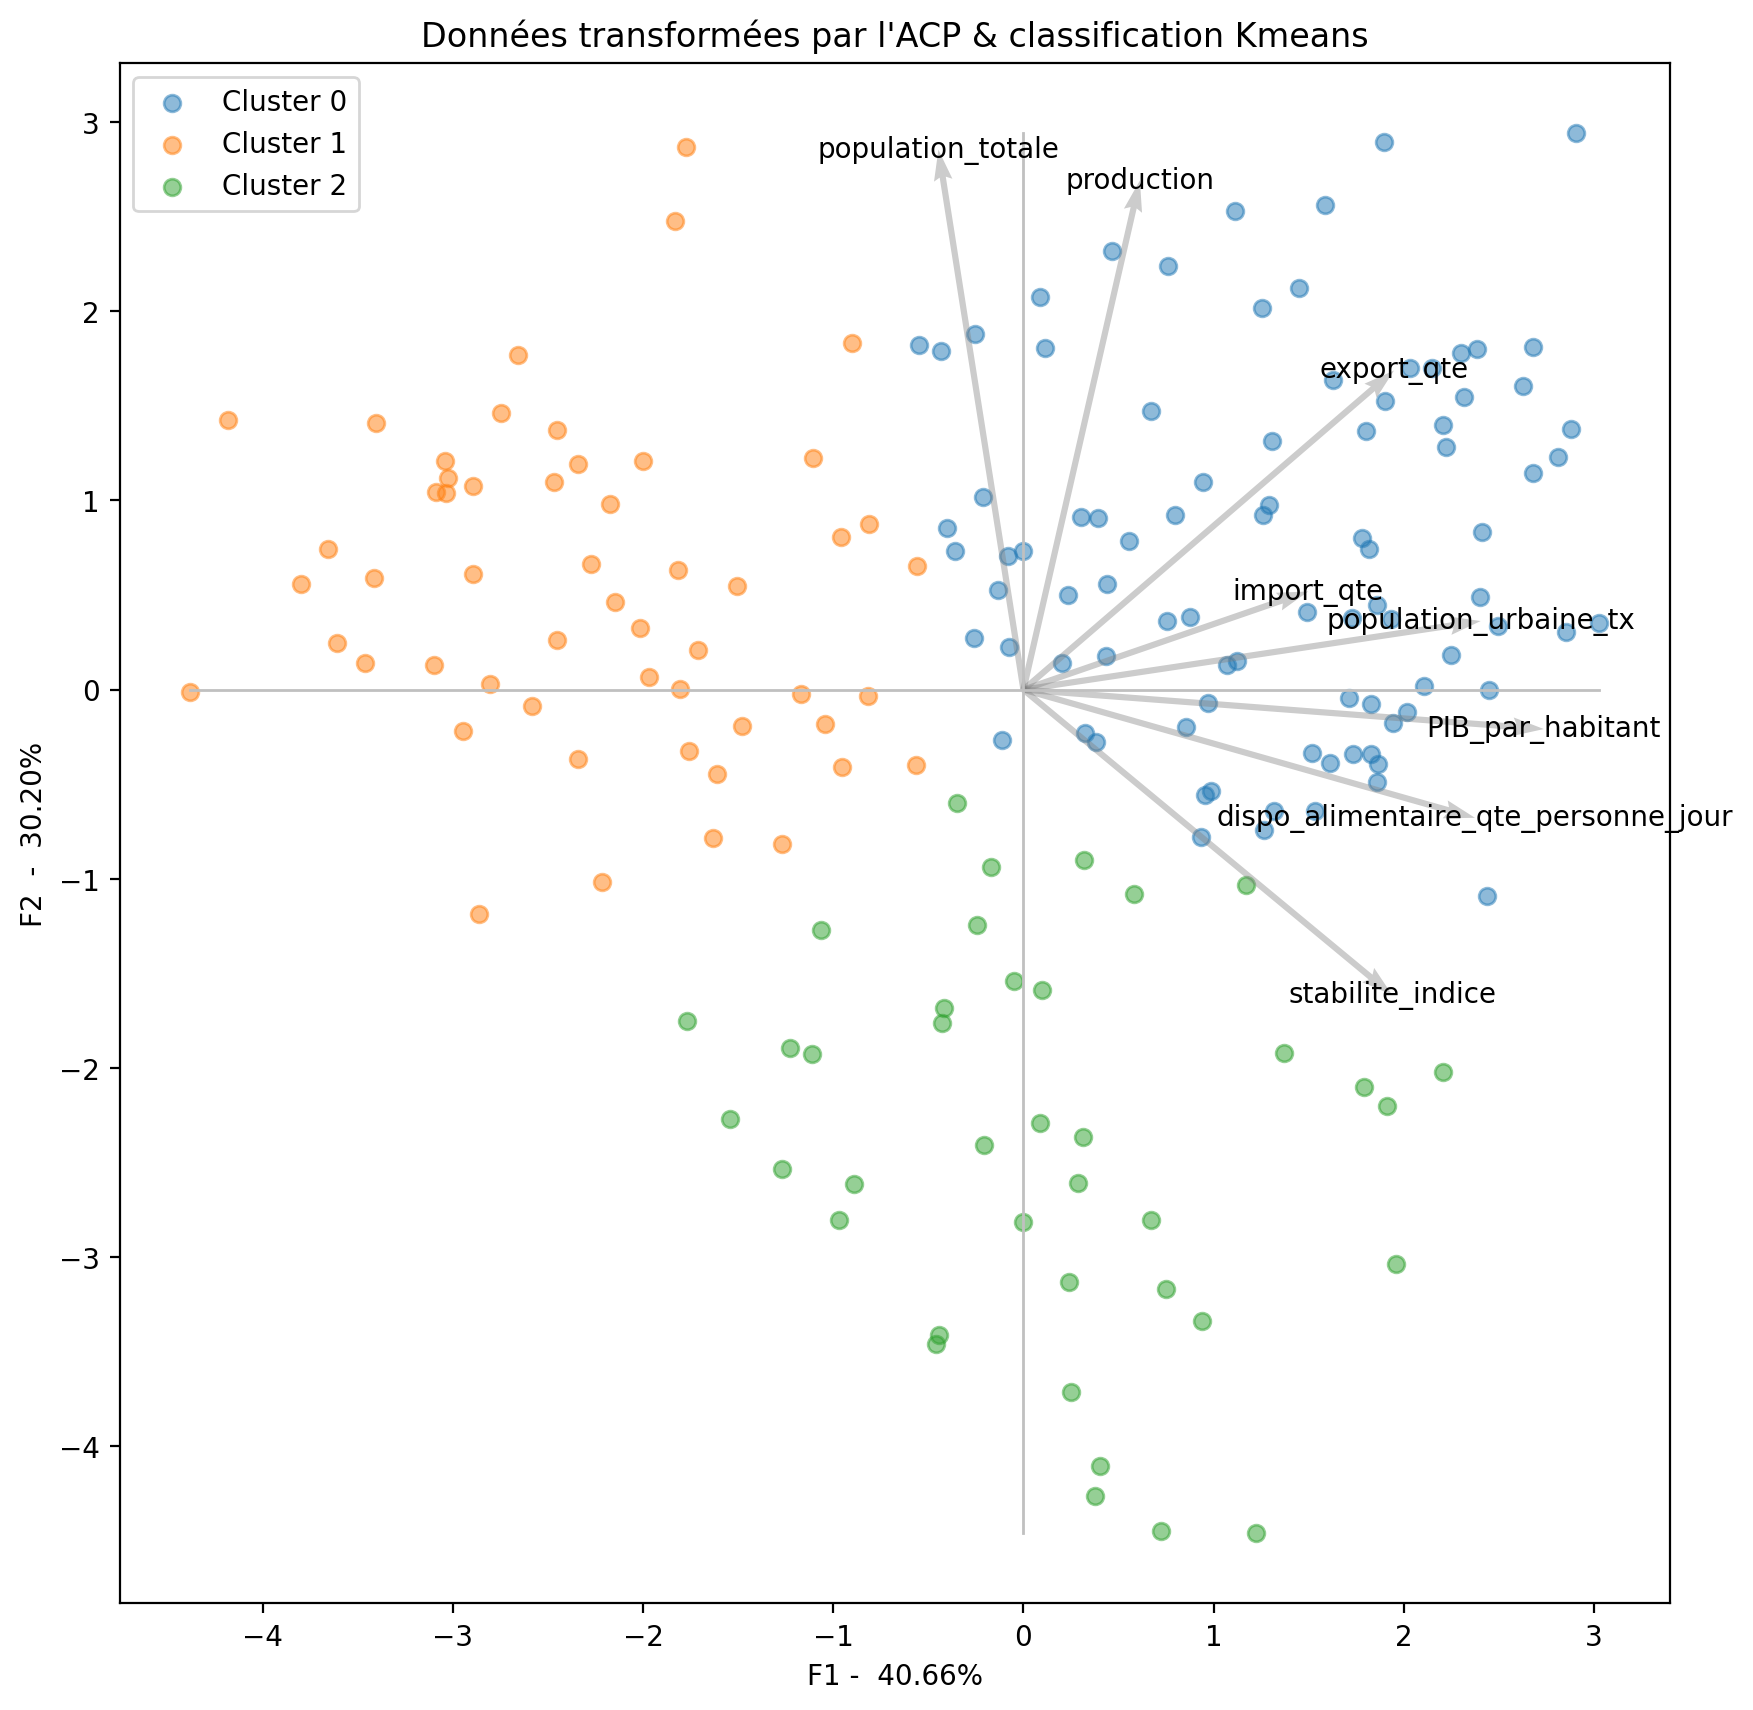

In [60]:
# Clusters kmeans et F1 / F2
plt.figure(figsize=(10,10), dpi=200)
n_clusters = len(set(km_cluster_labels))

# Créer un scatter plot pour chaque cluster avec une couleur différente
for cluster in range(n_clusters):
    plt.scatter(
        x=X_transform[km_cluster_labels == cluster, 0],
        y=X_transform[km_cluster_labels == cluster, 1],
        alpha=0.5,
        label=f'Cluster {cluster}'  # Etiquette pour la légende
    )   
plt.legend()

plt.plot([0, 0], (X_transform[:,1].min(), X_transform[:,1].max()), color='silver', linestyle='-', linewidth=1)
plt.plot((X_transform[:,0].min(), X_transform[:,0].max()), [0, 0], color='silver', linestyle='-', linewidth=1)

# Affiche les variables
for j in range(p):
    plt.annotate(
        text= X.columns[j],
        xy=(corr_var.iloc[j, 0]*3, corr_var.iloc[j, 1]*3),
        ha="center",
        va="center")

# Tracer les flèches à partir de l'origine (0,0) vers les points
for x, y in zip((corr_var.iloc[:, 0] * 3 ).tolist(), (corr_var.iloc[:, 1] *3).tolist()):
    plt.quiver(0, 0, x, y, angles='xy', scale_units='xy',
                scale=1, color='grey', alpha=0.4, width=0.004, lw=0.1)
    
plt.title("Données transformées par l'ACP & classification Kmeans")
plt.xlabel(f"F1 - {acp.acp.explained_variance_ratio_[0]: .2%}")
plt.ylabel(f"F2  - {acp.acp.explained_variance_ratio_[1]: .2%}")

plt.show()

### Analyse des clusters kmeans

In [61]:
col = ['population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'croissance_par_habitant', 'PIB_par_habitant',
       'stabilite_indice']

In [62]:
df_prep["categ_kmeans"] = df_prep["categ_kmeans"].astype(str)
df_prep["categ_ACH"] = df_prep["categ_ACH"].astype(str)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, Afghanistan to Zambie
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   population_totale                    182 non-null    float64
 1   population_urbaine_tx                182 non-null    float64
 2   dispo_alimentaire_qte_personne_jour  182 non-null    float64
 3   export_qte                           182 non-null    float64
 4   import_qte                           182 non-null    float64
 5   production                           182 non-null    float64
 6   croissance_par_habitant              182 non-null    float64
 7   PIB_par_habitant                     182 non-null    float64
 8   stabilite_indice                     182 non-null    float64
dtypes: float64(9)
memory usage: 18.3+ KB


Analyse des clusters

avec les données transformées

In [64]:
df_numeric = df_prep.select_dtypes(include='number')
# Ajouter la colonne catégorie
df_numeric['categ_kmeans'] = df_prep['categ_kmeans']


In [65]:
df_numeric.mean(numeric_only=True)

population_totale                      15.799848
population_urbaine_tx                   0.596469
dispo_alimentaire_qte_personne_jour     3.640634
export_qte                              5.041715
import_qte                              8.989494
production                             10.635508
PIB_par_habitant                        8.668071
stabilite_indice                       -0.121758
dtype: float64

In [66]:
df_numeric.shape

(182, 9)

In [67]:
df_numeric.columns

Index(['population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'PIB_par_habitant', 'stabilite_indice', 'categ_kmeans'],
      dtype='object')

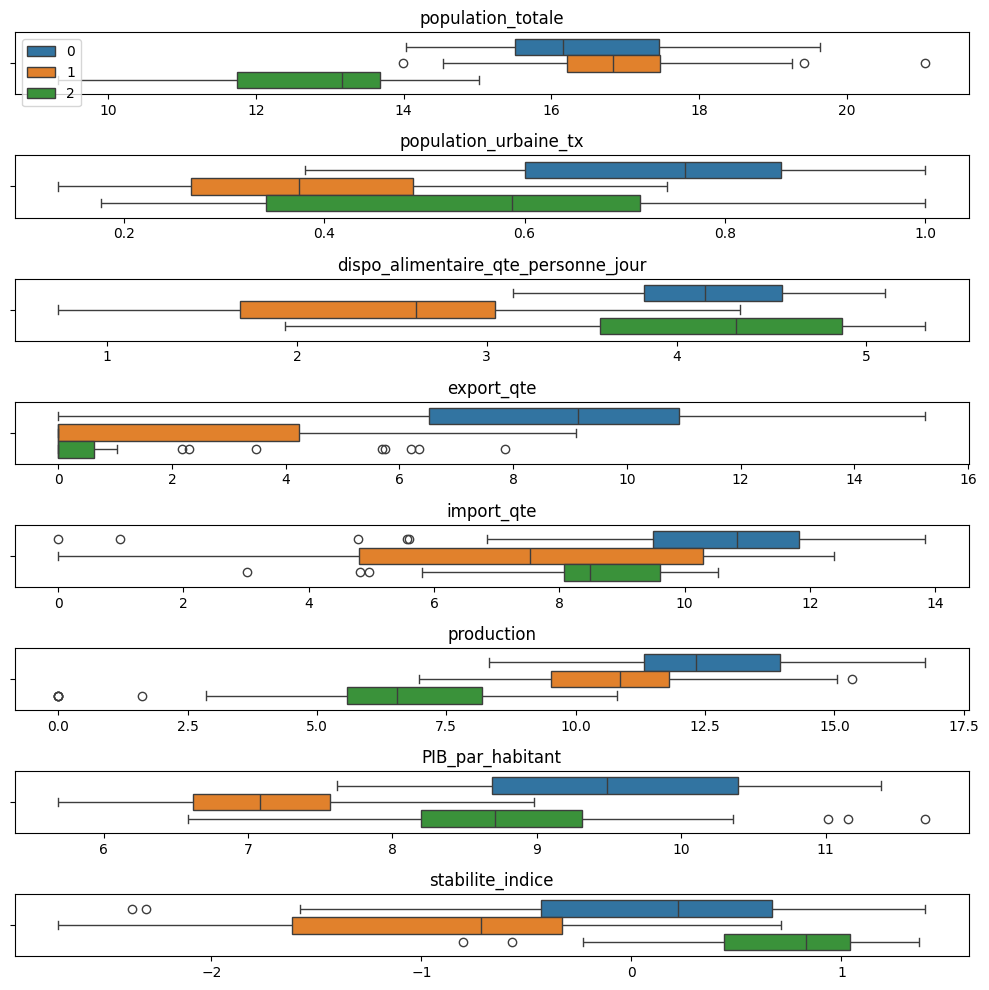

In [68]:
fig, ax = plt.subplots(8,1, figsize=(10,10))
for i, col in enumerate(df_numeric.iloc[:,:-1].columns):
    sns.boxplot(df_numeric, x=col, hue="categ_kmeans", ax=ax[i], orient="h", hue_order=["0", "1", "2"])
    # Ajout des moyennes avec pointplot
    ax[i].set_title(col)
    ax[i].set_xlabel(None)
        # Éviter la duplication de légendes
    if i == 0:
        ax[i].legend(loc='upper left')
    else:
        ax[i].legend_.remove()
plt.tight_layout()
plt.show()

In [69]:
df_original.drop(['code_pays', 'categ_ACH'])

KeyError: "['code_pays', 'categ_ACH'] not found in axis"

In [618]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [641]:

means_features_by_cat_kmeans = df_original.groupby("categ_kmeans")[df_original.select_dtypes(include='number').columns.values].mean().T
means_features_by_cat_kmeans

categ_kmeans                                  0           1         2
code_pays                                432.13      469.20    397.00
population_totale                   32181361.17 65017120.61 788245.49
population_urbaine_tx                      0.74        0.39      0.57
dispo_alimentaire_qte_personne_jour       70.83       14.21     86.02
export_qte                            164812.01      447.06    110.09
import_qte                            124187.63    21611.70   9563.47
production                           1011513.38   269611.29   4778.10
croissance_par_habitant                    4.51        3.03      3.63
PIB_par_habitant                       22220.05     1613.90  14041.09
stabilite_indice                           0.05       -0.99      0.69
categ_kmeans                               0.00        1.00      2.00
categ_ACH                                  0.03        0.94      1.74

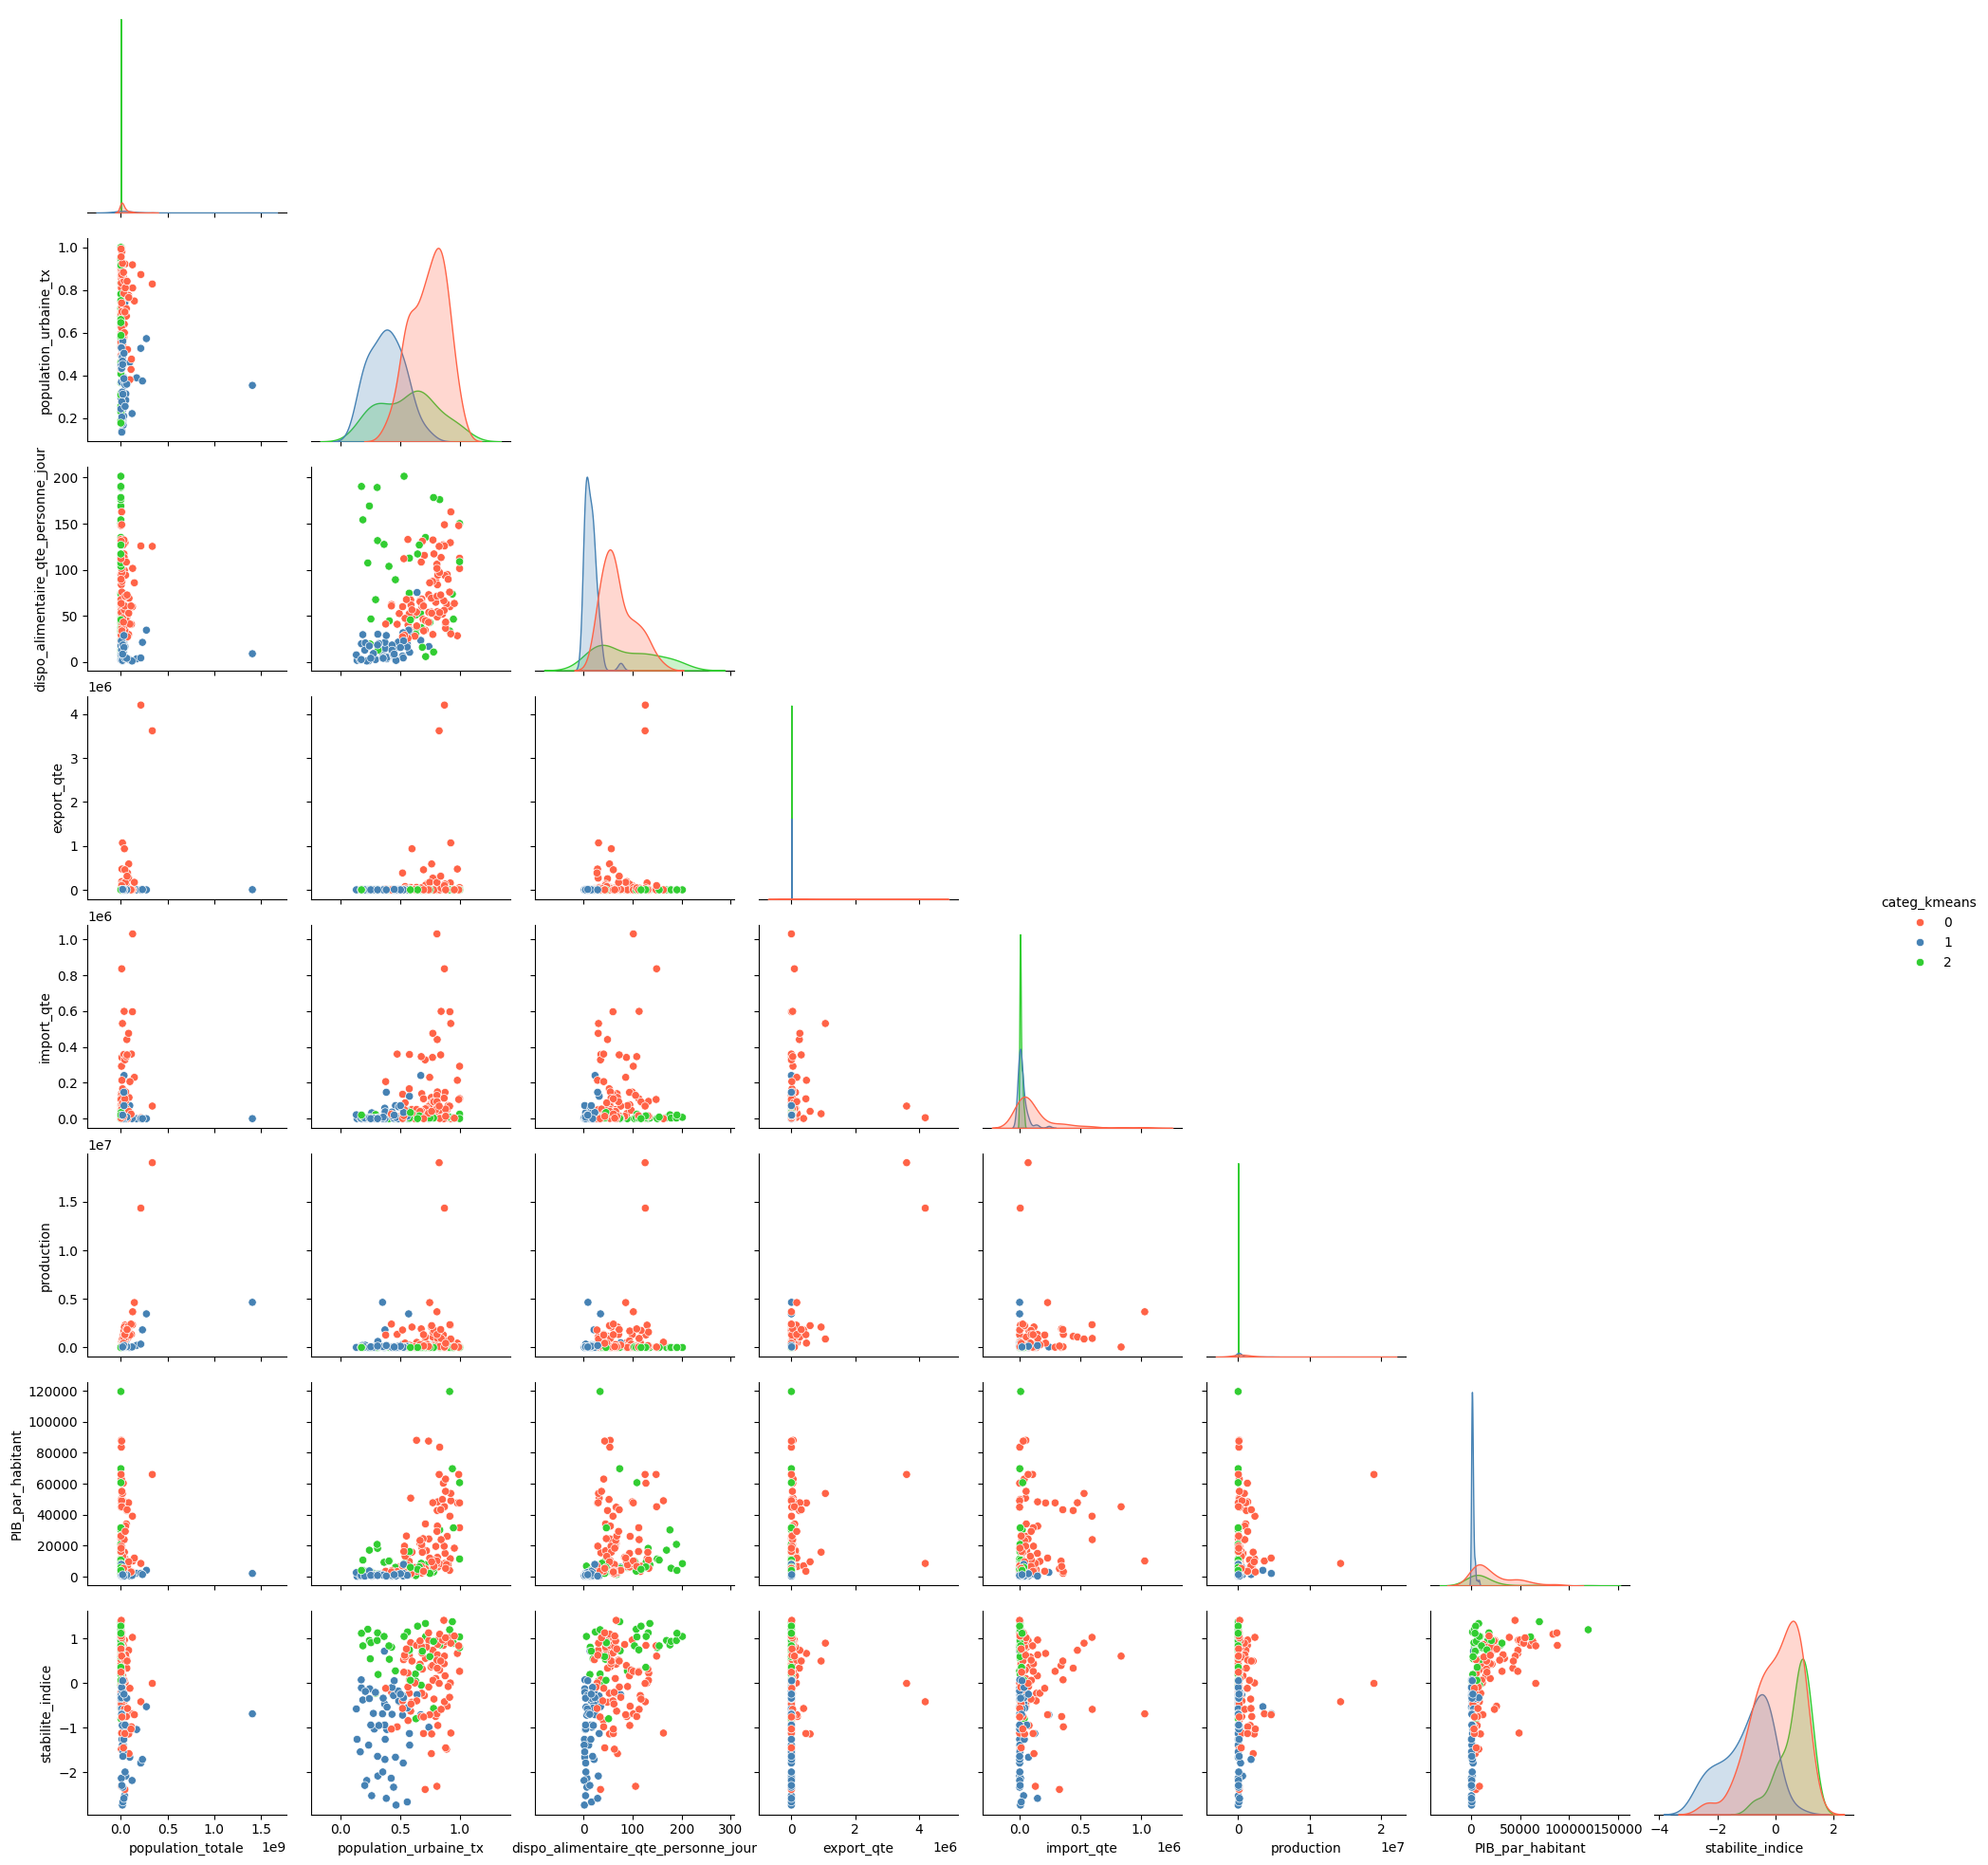

In [644]:
cols = ['population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'PIB_par_habitant',
       'stabilite_indice', 'categ_kmeans']

custom_palette = ["#FF6347", "#4682B4", "#32CD32"]
sns.pairplot(df_original[cols],
             hue="categ_kmeans",
             corner=True,
             kind="scatter",
             palette=custom_palette)
plt.show()

In [650]:
for cluster in np.sort(df_original["categ_kmeans"].unique()):
    print(f"Détail des caractéristiques du cluster {cluster}")
    display(df_original[df_original["categ_kmeans"] == cluster][cols].describe().T)

    print(f"Liste des pays du cluster {cluster}")
    print(df_original[df_original["categ_kmeans"] == cluster][cols].index.values)
    print("-"*150)

Détail des caractéristiques du cluster 0


count        mean         std        min  \
population_totale                    89.00 32181361.17 50611033.73 1244188.00   
population_urbaine_tx                89.00        0.74        0.15       0.38   
dispo_alimentaire_qte_personne_jour  89.00       70.83       33.62      22.10   
export_qte                           89.00   164812.01   600088.66       0.00   
import_qte                           89.00   124187.63   186893.68       0.00   
production                           89.00  1011513.38  2565341.08    4111.35   
PIB_par_habitant                     89.00    22220.05    21519.73    2035.29   
stabilite_indice                     89.00        0.05        0.79      -2.38   
categ_kmeans                         89.00        0.00        0.00       0.00   

                                           25%         50%         75%  \
population_totale                   5403021.00 10445365.00 38307726.00   
population_urbaine_tx                     0.60        0.76        0.86   
dispo_alimentaire_qte_personne_jour      45.01       62.34       94.24   
export_qte                              679.62     9320.55    55196.59   
import_qte                            13297.67    51032.50   135837.32   
production                            82421.00   224397.00  1143000.00   
PIB_par_habitant                       5942.12    13157.56    32646.82   
stabilite_indice                         -0.43        0.22        0.67   
categ_kmeans                              0.00        0.00        0.00   

                                             max  
population_totale                   336997624.00  
population_urbaine_tx                       1.00  
dispo_alimentaire_qte_personne_jour       162.84  
export_qte                            4201040.27  
import_qte                            1029674.12  
production                           19003499.00  
PIB_par_habitant                        87957.49  
stabilite_indice                            1.40  
categ_kmeans                                0.00

Liste des pays du cluster 0
['Azerbaïdjan' 'Argentine' 'Australie' 'Autriche' 'Bahreïn' 'Belgique'
 'Bolivie (État plurinational de)' 'Bosnie-Herzégovine' 'Brésil'
 'Bulgarie' 'Bélarus' 'Canada' 'Chili' 'Colombie' 'Congo' 'Costa Rica'
 'Croatie' 'Cuba' 'Chypre' 'Tchéquie' 'Danemark' 'République dominicaine'
 'El Salvador' 'Estonie' 'Finlande' 'France' 'Gabon' 'Géorgie' 'Allemagne'
 'Ghana' 'Grèce' 'Guatemala' 'Honduras' 'Chine - RAS de Hong-Kong'
 'Hongrie' "Iran (République islamique d')" 'Iraq' 'Irlande' 'Israël'
 'Italie' 'Jamaïque' 'Japon' 'Kazakhstan' 'Jordanie' 'République de Corée'
 'Koweït' 'Liban' 'Lettonie' 'Libye' 'Lituanie' 'Malaisie' 'Mexique'
 'République de Moldova' 'Maroc' 'Oman' 'Namibie' 'Pays-Bas (Royaume des)'
 'Nouvelle-Zélande' 'Nicaragua' 'Norvège' 'Panama' 'Paraguay' 'Pérou'
 'Philippines' 'Pologne' 'Portugal' 'Qatar' 'Roumanie'
 'Fédération de Russie' 'Arabie saoudite' 'Serbie' 'Slovaquie' 'Viet Nam'
 'Slovénie' 'Afrique du Sud' 'Espagne' 'Suède' 'Suisse' 'Thaï

count        mean          std  \
population_totale                    54.00 65017120.61 194793905.31   
population_urbaine_tx                54.00        0.39         0.15   
dispo_alimentaire_qte_personne_jour  54.00       14.21        12.63   
export_qte                           54.00      447.06      1514.94   
import_qte                           54.00    21611.70     43387.20   
production                           54.00   269611.29    801229.70   
PIB_par_habitant                     54.00     1613.90      1455.24   
stabilite_indice                     54.00       -0.99         0.83   
categ_kmeans                         54.00        1.00         0.00   

                                           min         25%         50%  \
population_totale                   1192271.00 10923096.25 20607054.50   
population_urbaine_tx                     0.13        0.27        0.38   
dispo_alimentaire_qte_personne_jour       1.10        4.47       12.87   
export_qte                                0.00        0.00        0.00   
import_qte                                0.00      120.94     1869.49   
production                             1060.13    13677.45    51762.39   
PIB_par_habitant                        293.57      747.47     1189.45   
stabilite_indice                         -2.73       -1.61       -0.71   
categ_kmeans                              1.00        1.00        1.00   

                                            75%           max  
population_totale                   38700540.00 1407563842.00  
population_urbaine_tx                      0.49          0.74  
dispo_alimentaire_qte_personne_jour       19.98         75.40  
export_qte                                68.91       8974.49  
import_qte                             29821.68     240448.80  
production                            135081.50    4641260.08  
PIB_par_habitant                        1932.17       7961.16  
stabilite_indice                          -0.33          0.71  
categ_kmeans                               1.00          1.00

Liste des pays du cluster 1
['Afghanistan' 'Algérie' 'Angola' 'Bangladesh' 'Myanmar' 'Burundi'
 'Cambodge' 'Cameroun' 'République centrafricaine' 'Sri Lanka' 'Tchad'
 'République démocratique du Congo' 'Bénin' 'Équateur' 'Éthiopie' 'Guinée'
 'Haïti' 'Inde' 'Indonésie' "Côte d'Ivoire" 'Kenya' 'Kirghizistan'
 'République démocratique populaire lao' 'Lesotho' 'Libéria' 'Madagascar'
 'Malawi' 'Mali' 'Mauritanie' 'Mozambique' 'Népal' 'Niger' 'Nigéria'
 'Pakistan' 'Papouasie-Nouvelle-Guinée' 'Guinée-Bissau' 'Rwanda' 'Sénégal'
 'Sierra Leone' 'Somalie' 'Zimbabwe' 'Soudan du Sud' 'Soudan' 'Eswatini'
 'République arabe syrienne' 'Tadjikistan' 'Togo' 'Turkménistan' 'Ouganda'
 'République-Unie de Tanzanie' 'Burkina Faso' 'Ouzbékistan' 'Yémen'
 'Zambie']
------------------------------------------------------------------------------------------------------------------------------------------------------
Détail des caractéristiques du cluster 2


count      mean       std      min  \
population_totale                    39.00 788245.49 913387.48 11204.00   
population_urbaine_tx                39.00      0.57      0.24     0.18   
dispo_alimentaire_qte_personne_jour  39.00     86.02     59.86     5.92   
export_qte                           39.00    110.09    425.62     0.00   
import_qte                           39.00   9563.47   9973.70    19.53   
production                           39.00   4778.10   9498.75     0.00   
PIB_par_habitant                     39.00  14041.09  22644.80   723.84   
stabilite_indice                     39.00      0.69      0.51    -0.80   
categ_kmeans                         39.00      2.00      0.00     2.00   

                                          25%       50%       75%        max  
population_totale                   126742.00 521457.00 873117.50 3347782.00  
population_urbaine_tx                    0.34      0.59      0.71       1.00  
dispo_alimentaire_qte_personne_jour     35.54     73.67    129.63     201.49  
export_qte                               0.00      0.00      0.86    2569.67  
import_qte                            3237.56   4869.85  14823.86   37733.64  
production                             265.18    701.17   3643.37   49100.00  
PIB_par_habitant                      3633.49   6069.16  11090.95  119400.27  
stabilite_indice                         0.44      0.83      1.04       1.37  
categ_kmeans                             2.00      2.00      2.00       2.00

Liste des pays du cluster 2
['Albanie' 'Antigua-et-Barbuda' 'Bahamas' 'Arménie' 'Barbade' 'Bhoutan'
 'Botswana' 'Belize' 'Îles Salomon' 'Cabo Verde' 'Comores' 'Dominique'
 'Fidji' 'Djibouti' 'Gambie' 'Kiribati' 'Grenade' 'Islande' 'Luxembourg'
 'Chine - RAS de Macao' 'Maldives' 'Malte' 'Maurice' 'Mongolie'
 'Monténégro' 'Nauru' 'Vanuatu' 'Micronésie (États fédérés de)'
 'Îles Marshall' 'Timor-Leste' 'Saint-Kitts-et-Nevis' 'Sainte-Lucie'
 'Saint-Vincent-et-les Grenadines' 'Sao Tomé-et-Principe' 'Seychelles'
 'Suriname' 'Tuvalu' 'Macédoine du Nord' 'Samoa']
------------------------------------------------------------------------------------------------------------------------------------------------------


In [652]:
df_cluster1 = df_original[df_original["categ_kmeans"] == 1].copy()
df_cluster1["pays"] = df_cluster1.index

<Axes: xlabel='population_totale', ylabel='import_qte'>

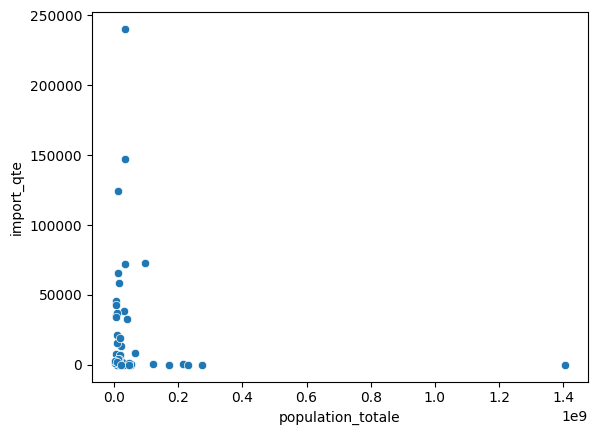

In [653]:
sns.scatterplot(df_cluster1, x="population_totale", y="import_qte",)

In [657]:
dict_hover = {col: True for col in df_cluster1.columns}

In [658]:
df_cluster1.shape[0]

54

In [659]:
df_cluster1.columns

Index(['code_pays', 'population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'croissance_par_habitant', 'PIB_par_habitant',
       'stabilite_indice', 'categ_kmeans', 'categ_ACH', 'pays'],
      dtype='object')

In [661]:
# Selection des pays du cluster sélectionné

filtred = df_cluster1[df_cluster1["stabilite_indice"] > -1]
filtred.shape

(32, 13)

In [662]:
filtred.sort_values("population_totale", ascending=False)

code_pays  population_totale  \
pays                                                                  
Inde                                         356      1407563842.00   
Indonésie                                    360       273753191.00   
République-Unie de Tanzanie                  834        63588334.00   
Ouganda                                      800        45853778.00   
Algérie                                       12        44177969.00   
Angola                                        24        34503774.00   
Ouzbékistan                                  860        34081449.00   
Népal                                        524        30034989.00   
Madagascar                                   450        28915653.00   
Côte d'Ivoire                                384        27478249.00   
Sri Lanka                                    144        21773441.00   
Malawi                                       454        19889742.00   
Zambie                                       894        19473125.00   
Équateur                                     218        17797737.00   
Sénégal                                      686        16876720.00   
Cambodge                                     116        16589023.00   
Zimbabwe                                     716        15993524.00   
Guinée                                       324        13531906.00   
Rwanda                                       646        13461888.00   
Bénin                                        204        12996895.00   
Papouasie-Nouvelle-Guinée                    598         9949437.00   
Tadjikistan                                  762         9750064.00   
Togo                                         768         8644829.00   
Sierra Leone                                 694         8420641.00   
République démocratique populaire lao        418         7425057.00   
Kirghizistan                                 417         6527743.00   
Turkménistan                                 795         6341855.00   
Libéria                                      430         5193416.00   
Mauritanie                                   478         4614974.00   
Lesotho                                      426         2281454.00   
Guinée-Bissau                                624         2060721.00   
Eswatini                                     748         1192271.00   

                                       population_urbaine_tx  \
pays                                                           
Inde                                                    0.35   
Indonésie                                               0.57   
République-Unie de Tanzanie                             0.36   
Ouganda                                                 0.26   
Algérie                                                 0.74   
Angola                                                  0.67   
Ouzbékistan                                             0.50   
Népal                                                   0.21   
Madagascar                                              0.39   
Côte d'Ivoire                                           0.52   
Sri Lanka                                               0.19   
Malawi                                                  0.18   
Zambie                                                  0.45   
Équateur                                                0.64   
Sénégal                                                 0.49   
Cambodge                                                0.25   
Zimbabwe                                                0.32   
Guinée                                                  0.37   
Rwanda                                                  0.18   
Bénin                                                   0.49   
Papouasie-Nouvelle-Guinée                               0.13   
Tadjikistan                                             0.28   
Togo                                                    0.43   
Sierra Leone            

In [664]:
filtred.nlargest(10,"import_qte")

code_pays  population_totale  \
pays                                                      
Angola                            24        34503774.00   
Ouzbékistan                      860        34081449.00   
Bénin                            204        12996895.00   
Guinée                           324        13531906.00   
Libéria                          430         5193416.00   
Mauritanie                       478         4614974.00   
Sierra Leone                     694         8420641.00   
Kirghizistan                     417         6527743.00   
Turkménistan                     795         6341855.00   
Papouasie-Nouvelle-Guinée        598         9949437.00   

                           population_urbaine_tx  \
pays                                               
Angola                                      0.67   
Ouzbékistan                                 0.50   
Bénin                                       0.49   
Guinée                                      0.37   
Libéria                                     0.53   
Mauritanie                                  0.56   
Sierra Leone                                0.43   
Kirghizistan                                0.37   
Turkménistan                                0.53   
Papouasie-Nouvelle-Guinée                   0.13   

                           dispo_alimentaire_qte_personne_jour  export_qte  \
pays                                                                         
Angola                                                   23.49        1.87   
Ouzbékistan                                              15.75      100.59   
Bénin                                                    15.81        0.00   
Guinée                                                   14.85        0.00   
Libéria                                                  31.73       55.87   
Mauritanie                                               19.63       17.88   
Sierra Leone                                             18.43        0.00   
Kirghizistan                                             20.99        0.00   
Turkménistan                                             22.93        0.00   
Papouasie-Nouvelle-Guinée                                 7.75        0.00   

                           import_qte  production  croissance_par_habitant  \
pays                                                                         
Angola                      240448.80    55384.74                     3.42   
Ouzbékistan                  72438.36   123600.00                    -1.23   
Bénin                        65653.04     9359.40                     3.80   
Guinée                       58354.37    14996.93                    13.32   
Libéria                      45874.28    14336.68                     1.16   
Mauritanie                   42475.48     3992.52                     6.73   
Sierra Leone                 36903.30    19748.04                    -3.58   
Kirghizistan                 35887.70    11069.00                     7.06   
Turkménistan                 34156.72    21555.00                     9.40   
Papouasie-Nouvelle-Guinée    21446.58     6708.40                     5.21   

                           PIB_par_habitant  stabilite_indice  categ_kmeans  \
pays                                                                          
Angola                              2783.81             -0.71             1   
Ouzbékistan                         1926.80             -0.25             1   
Bénin                               1227.53             -0.40             1   
Guinée                              1094.93             -0.94             1   
Libéria                              551.70             -0.29             1   
Mauritanie                          1930.17             -0.56             1   
Sierra Leone                         485.98             -0.10             1   
Kirghizistan                        1364.80             -0.47             1   
Turkménistan                 

In [665]:
# Import du fichier avec code pays
code_pays_iso = pd.read_csv("data/code_pays.csv")
code_pays_iso.head()

name alpha-2 alpha-3  country-code     iso_3166-2   region  \
0     Afghanistan      AF     AFG             4  ISO 3166-2:AF     Asia   
1   Åland Islands      AX     ALA           248  ISO 3166-2:AX   Europe   
2         Albania      AL     ALB             8  ISO 3166-2:AL   Europe   
3         Algeria      DZ     DZA            12  ISO 3166-2:DZ   Africa   
4  American Samoa      AS     ASM            16  ISO 3166-2:AS  Oceania   

        sub-region intermediate-region  region-code  sub-region-code  \
0    Southern Asia                 NaN       142.00            34.00   
1  Northern Europe                 NaN       150.00           154.00   
2  Southern Europe                 NaN       150.00            39.00   
3  Northern Africa                 NaN         2.00            15.00   
4        Polynesia                 NaN         9.00            61.00   

   intermediate-region-code  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN

In [667]:
df.shape

(182, 9)

In [668]:
df_4 = df_original.merge(right=code_pays_iso, left_on="code_pays", right_on="country-code")

In [669]:
df_4.columns

Index(['code_pays', 'population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'croissance_par_habitant', 'PIB_par_habitant',
       'stabilite_indice', 'categ_kmeans', 'categ_ACH', 'name', 'alpha-2',
       'alpha-3', 'country-code', 'iso_3166-2', 'region', 'sub-region',
       'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code'],
      dtype='object')

In [670]:
df_4["categ_kmeans"] = df_4["categ_kmeans"].astype(int)
df_4["categ_ACH"] = df_4["categ_ACH"].astype(int)

In [671]:
df_original.columns

Index(['code_pays', 'population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'croissance_par_habitant', 'PIB_par_habitant',
       'stabilite_indice', 'categ_kmeans', 'categ_ACH'],
      dtype='object')

In [673]:
fig2=px.choropleth(
    df_4,
    locations="alpha-3",  # Code pays ISO 3166-1 alpha-3
    locationmode="ISO-3",
    color="categ_kmeans",  # Variable à afficher
    hover_name='pays',  # Nom du pays au survol
    color_discrete_map ="Viridis",  # Échelle de couleurs
    projection="equirectangular",  # Projection de la carte,
    hover_data={col: True for col in colonne_affichage_carte},
    # color_continuous_scale="Viridis",
    range_color=(0, 2),
    # animation_group = "categ_kmeans",
    title="categ kmeans",
    width=1200,
    height=900
)
fig2.show()

In [675]:
colonne_affichage_carte = ['population_totale', 'population_urbaine_tx',
       'dispo_alimentaire_qte_personne_jour', 'export_qte', 'import_qte',
       'production', 'PIB_par_habitant', 'stabilite_indice', 'categ_kmeans',
       'categ_ACH',]

df_4["pays"] = df_4.index

import plotly.express as px

for col in colonne_affichage_carte :
    fig = px.choropleth(
        df_4,
        locations="alpha-3",  # Code pays ISO 3166-1 alpha-3
        locationmode="ISO-3",
        color=col,  # Variable à afficher
        hover_name="pays",  # Nom du pays au survol
        color_discrete_map ="Viridis",  # Échelle de couleurs
        projection="equirectangular",  # Projection de la carte,
        # hover_data={col: True for col in colonne_affichage_carte},
        animation_group = "categ_kmeans",
        title=f"{col}",
        width=1100,
        height=900
    )

    # Afficher la carte
    fig.show()